In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append('..')
import tf_data

from data_tools import convert_df

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['legend.loc'] = "best"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare data

In [2]:
data_ele = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/calo_matched/*.proto"}
data_gamma = {"gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/training/calo_matched/*.proto"}
data_nomatch = {"ele_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v8/training/no_calo_matched/*.proto",
                "gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v8/training/no_calo_matched/*.proto"}

features = {"cl_features": [ "en_cluster", "et_cluster", "cluster_ieta", "cluster_iphi", "cluster_iz"], "window_metadata":["sim_true_eta", "truePU", "rho", "wtot_simen_PU"],
           "seed_features": ["seed_eta"], "window_features":["max_en_cluster", "max_et_cluster"]}

In [4]:
# 1: cluster features, 2: window features, 3: cluster hits, 4: is seed, 
# 5: number clusters, 6: in SC, 7: windows metadata (+seed feat), 8: cl_labels 

In [5]:
n = 100000
df_ele = convert_df(data_ele, features, n)
print(df_ele.head(3))
df_gamma = convert_df(data_gamma, features, n)
print(df_gamma.head(3))
df_nomatch = convert_df(data_nomatch, features, n)

     en_cluster  et_cluster  cluster_ieta  cluster_iphi  cluster_iz  is_seed  \
0 0   43.235367   39.900761          24.0         220.0         0.0        1   
  1    1.186505    1.099017          23.0         190.0         0.0        0   
  2    0.535921    0.485220          26.0         230.0         0.0        0   

     n_cl  in_sc  sim_true_eta     truePU        rho  wtot_simen_PU  seed_eta  
0 0     7      1      0.406028  65.161919  44.720039       2.802057  0.406039  
  1     7      0      0.406028  65.161919  44.720039       2.802057  0.406039  
  2     7      0      0.406028  65.161919  44.720039       2.802057  0.406039  
     en_cluster  et_cluster  cluster_ieta  cluster_iphi  cluster_iz  is_seed  \
0 0  383.423553   40.911747          49.0          39.0        -1.0        1   
1 0   27.426331    5.598795          29.0          59.0        -1.0        1   
  1    2.076337    0.400161          35.0          65.0        -1.0        0   

     n_cl  in_sc  sim_true_eta     tru

In [6]:
df = [df_ele, df_gamma, df_nomatch]
df_title = ['electron matched', 'gamma matched', 'no-matched']

In [7]:
ele_seed = df_ele[df_ele['is_seed']==1]
gamma_seed = df_gamma[df_gamma['is_seed']==1]
nomatch_seed = df_nomatch[df_nomatch['is_seed']==1]

df_seed = [ele_seed, gamma_seed, nomatch_seed]

In [8]:
ele_seed.head(3)

,,en_cluster,et_cluster,cluster_ieta,cluster_iphi,cluster_iz,is_seed,n_cl,in_sc,sim_true_eta,truePU,rho,wtot_simen_PU,seed_eta
0,0,43.235367,39.900761,24.0,220.0,0.0,1,7,1,0.406028,65.161919,44.720039,2.802057,0.406039
1,0,261.500244,89.965118,32.0,85.0,1.0,1,2,1,1.729208,66.833580,30.172663,0.395370,1.729163
2,0,175.677719,88.493416,-75.0,204.0,0.0,1,6,1,-1.308119,64.415710,35.057693,0.642507,-1.308375


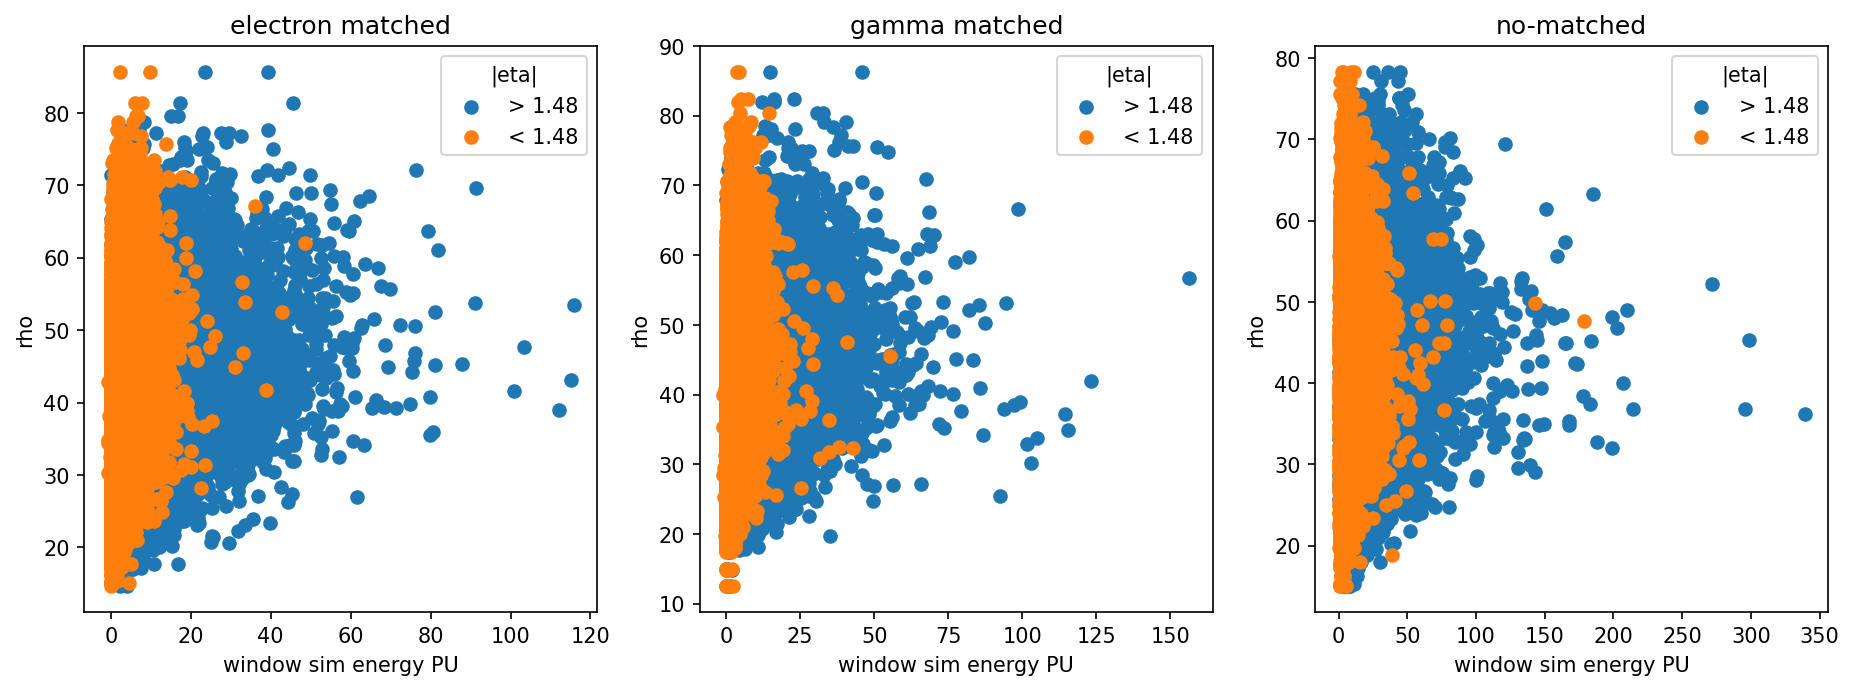

In [11]:
fig, axis = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(df_seed)):
    ax = axis[i]
    ax.set_title(df_title[i])
    end = df_seed[i][abs(df_seed[i]['seed_eta'])>1.48]
    bar = df_seed[i][abs(df_seed[i]['seed_eta'])<=1.48]
    ax.scatter(end['wtot_simen_PU'], end['rho'], label='> 1.48')
    ax.scatter(bar['wtot_simen_PU'], bar['rho'], label='< 1.48')
    ax.set_xlabel('window sim energy PU')
    ax.set_ylabel('rho')
    ax.legend(title='|eta|')

In [12]:
def en_mean(data, bins=10, cond=True, x='seed_eta'):
    eta = data[x].dropna()
    _, bin_edges = np.histogram(eta, bins=bins)
    en_mean = []
    for i in range(bins): 
        en = data['wtot_simen_PU'][cond&(data[x]>=bin_edges[i])&(data[x]<bin_edges[i+1])]
        en_mean.append(en.mean())
        
    bin_edges += (bin_edges[1]-bin_edges[0])/2
    return np.asarray(en_mean), bin_edges[:-1]

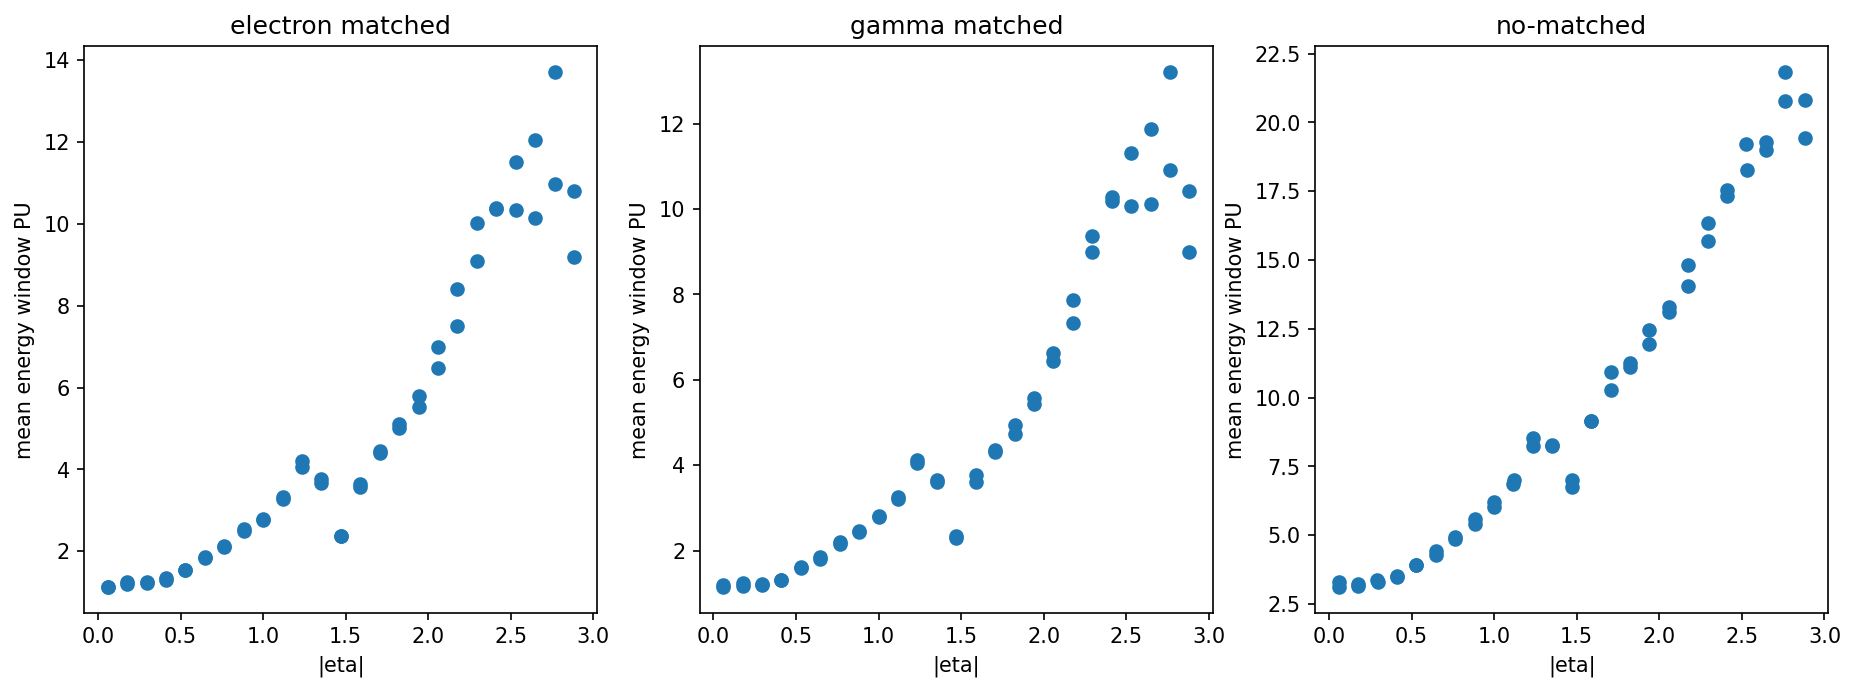

In [13]:
fig, axis = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(df_seed)):
    ax = axis[i]
    ax.set_title(df_title[i])
    energy, eta = en_mean(df_seed[i], 50, x='seed_eta')
    ax.scatter(abs(eta), energy)
    
    ax.set_ylabel('mean energy window PU')
    ax.set_xlabel('|eta|')

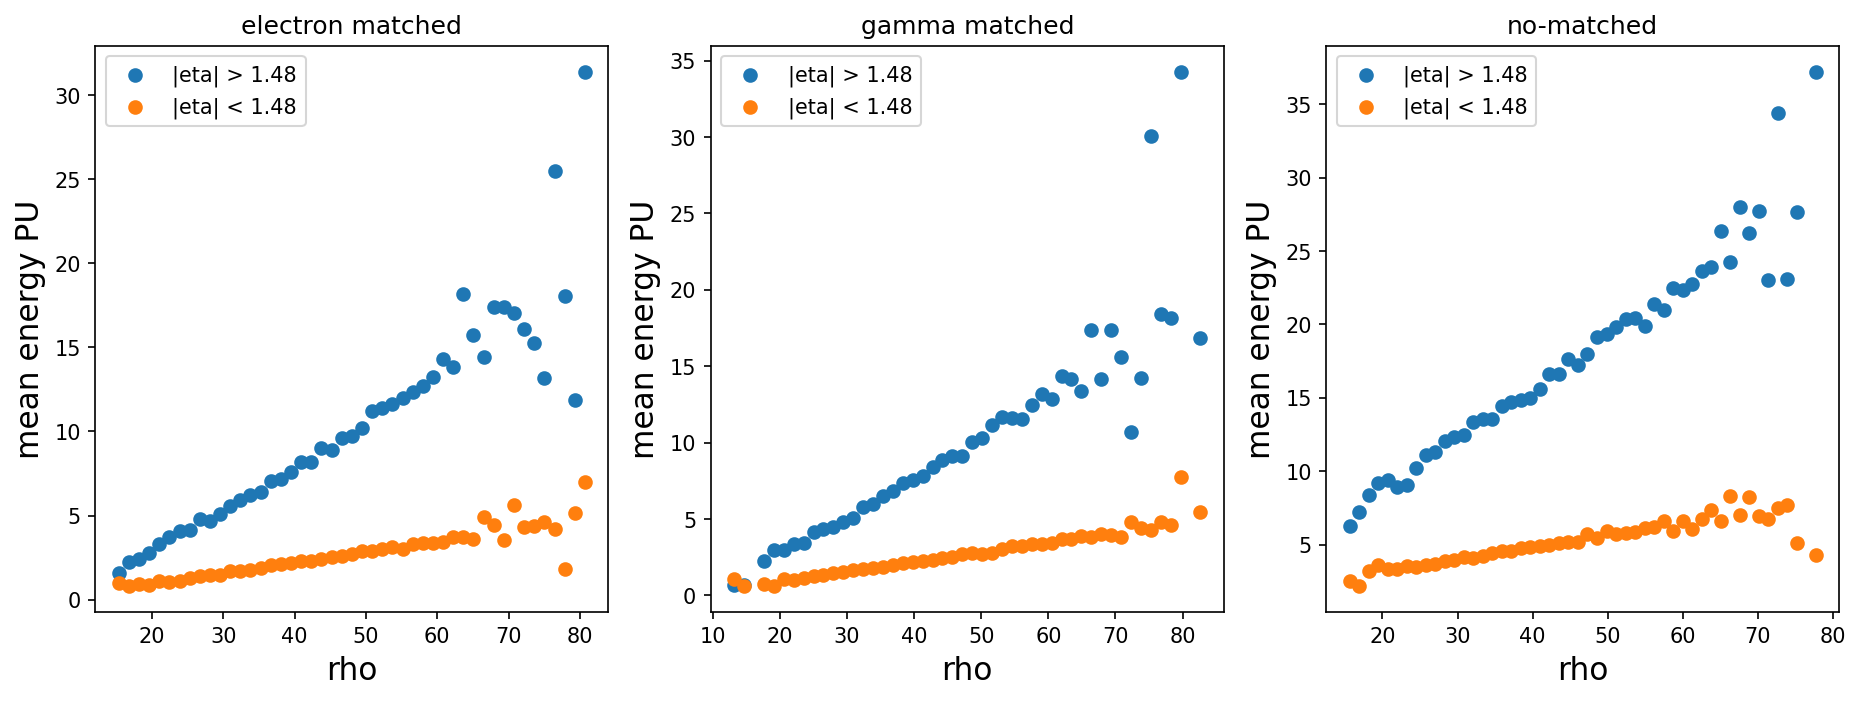

In [14]:
fig, axis = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(df_seed)):
    ax = axis[i]
    ax.set_title(df_title[i])
    energy, eta = en_mean(df_seed[i], 50, cond=(abs(df_seed[i]['seed_eta'])>1.48), x='rho')
    ax.scatter(abs(eta), energy, label='|eta| > 1.48')
    
    
    energy, eta = en_mean(df_seed[i], 50, cond=(abs(df_seed[i]['seed_eta'])<=1.48), x='rho')
    ax.scatter(abs(eta), energy, label='|eta| < 1.48')
    
    ax.set_ylabel('mean energy PU',fontsize=15)
    ax.set_xlabel('rho', fontsize=15)
    ax.legend()

# Distributions

In [15]:
# energy range
energy_range = [[0,30], [30,60], [60,100]]
energy_title = ['0 - 30', '30 - 60', '60 - 100']

# number of clusters range
ncl_range = [np.arange(1,10), np.arange(10,20), np.arange(20,30)]
ncl_title = ['1-9', '10-19', '20-29']

Text(0.5, 0.0, 'true PU')

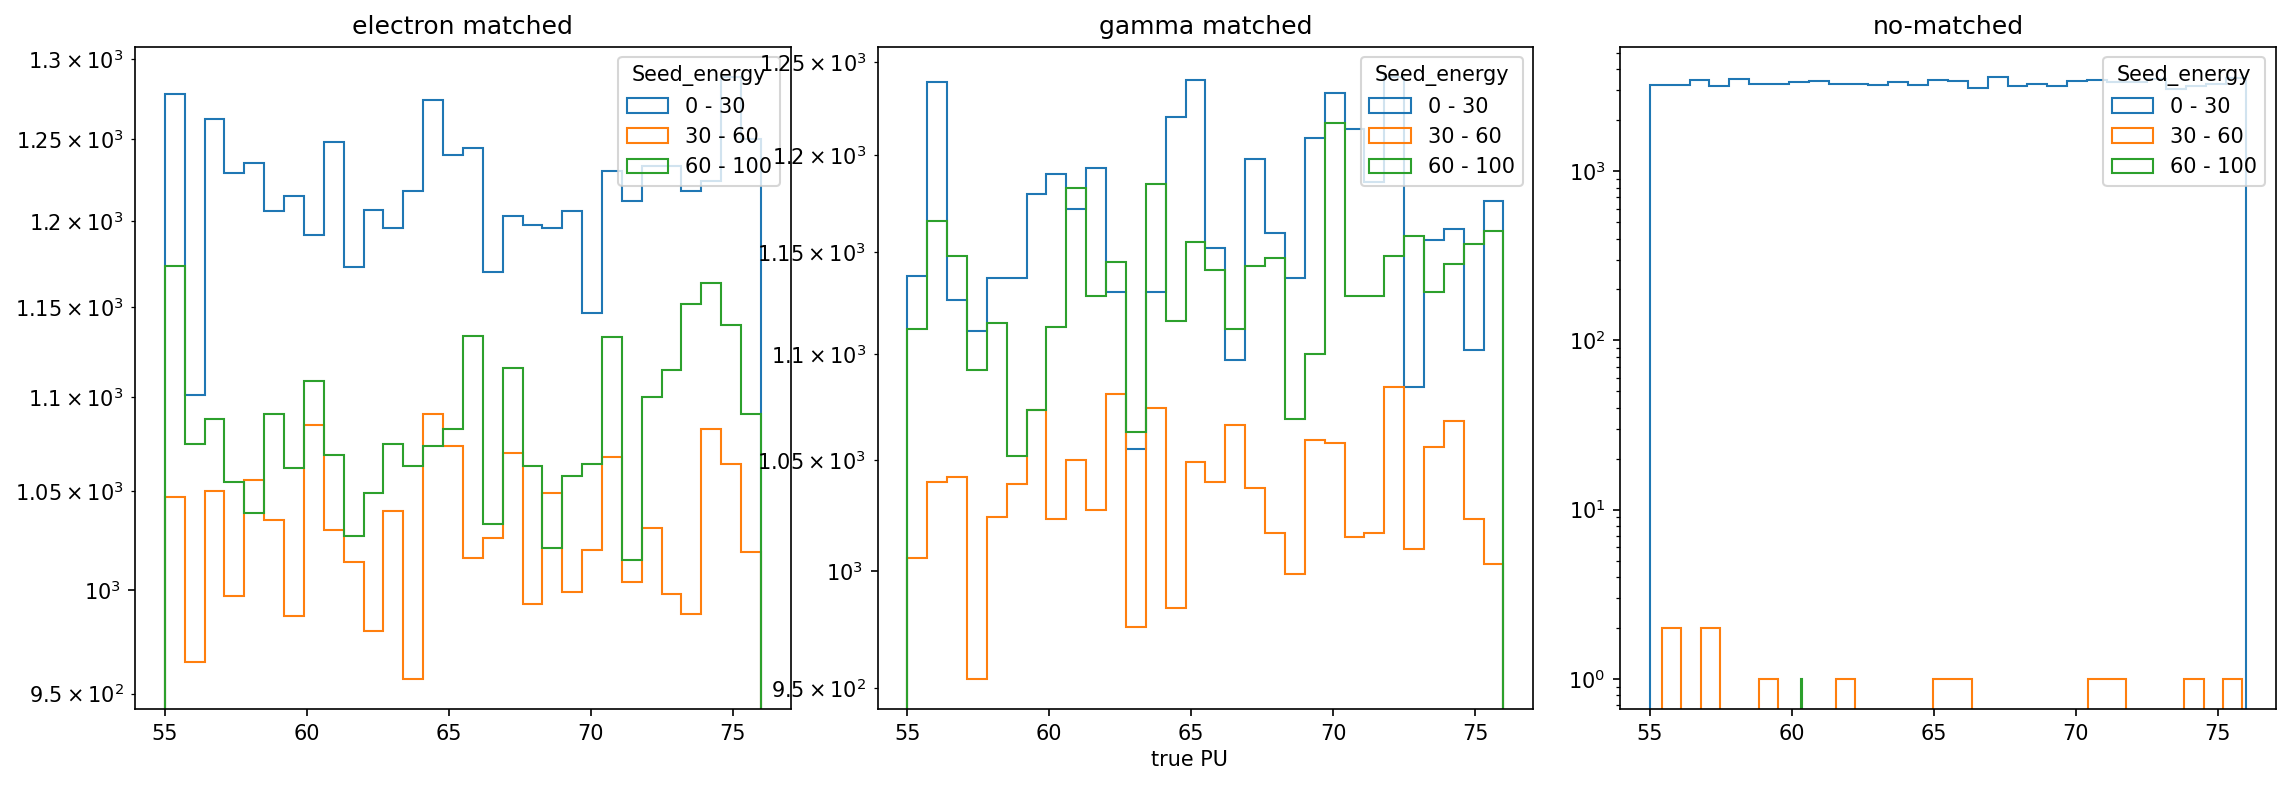

In [16]:
fig, axis = plt.subplots(1, 3, figsize=(15,5))
fig.tight_layout()

for i in range(len(df_seed)):
    ax = axis[i]
    ax.set_title(df_title[i])
    for j, en in enumerate(energy_range):
        ax.hist(df_seed[i]['truePU'][(df_seed[i]['et_cluster']>=en[0])&(df_seed[i]['et_cluster']<en[1])], label=energy_title[j], bins=30, histtype="step")
    ax.set_yscale("log")
    ax.legend(title="Seed_energy")
    
fig.text(0.5, 0., 'true PU', ha='center')
#fig.text(0.08, 0.25, '# of clusters', va='center', rotation='vertical')

In [17]:
def draw_seed(variable):
    fig, axis = plt.subplots(2, 3, figsize=(15,10))

    for i in range(len(df)):
        n_cl = df[i][variable][df[i]['is_seed'] == 1.]

        ax = axis[0,i]
        ax.hist(n_cl, bins=30, histtype="step")
        ax.set_title(df_title[i])
        ax.set_yscale("log")

        ax = axis[1, i]
        for j, n in enumerate(ncl_range):
            ax.hist(df[i][variable][df[i]['is_seed'] == 1.][df[i]['n_cl'].isin(n)], label=ncl_title[j], bins=30, histtype="step")
            ax.set_yscale("log")
            ax.legend(title="N of clusters")
    fig.text(0.5, 0.08, variable+ ' of the seed', ha='center')

# Number of clusters per window

Text(0.5, 0.04, 'number of clusters')

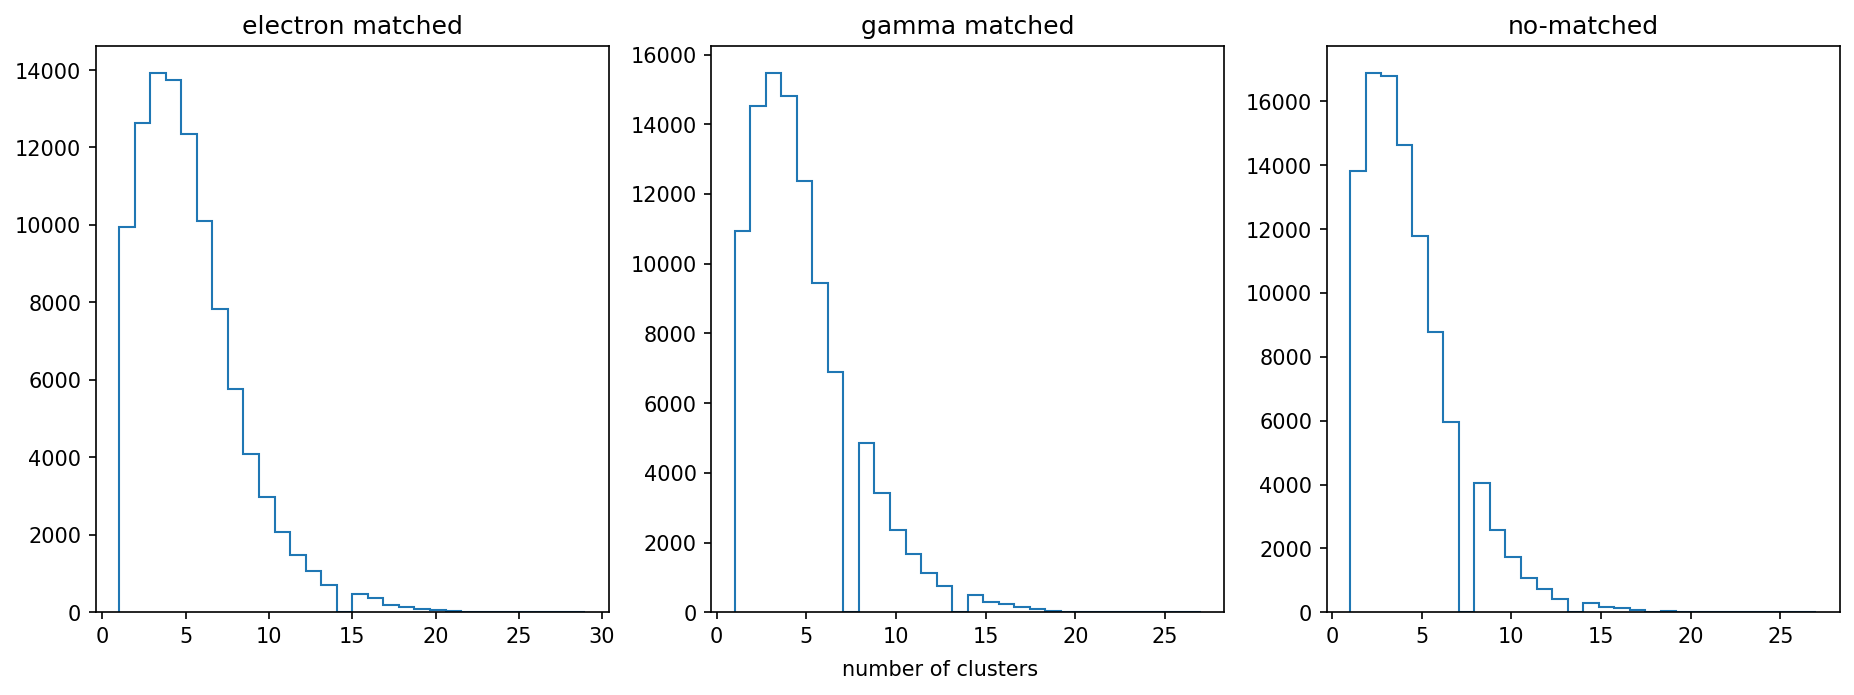

In [18]:
fig, axis = plt.subplots(1, 3, figsize=(15,5))

for i in range(len(df)):
    n_cl = df[i]['n_cl'][df[i]['is_seed'] == 1.]
    
    ax = axis[i]
    ax.hist(n_cl, bins=30, histtype="step")
    ax.set_title(df_title[i])

fig.text(0.5, 0.04, 'number of clusters', ha='center')

# Energy distribution of the seed

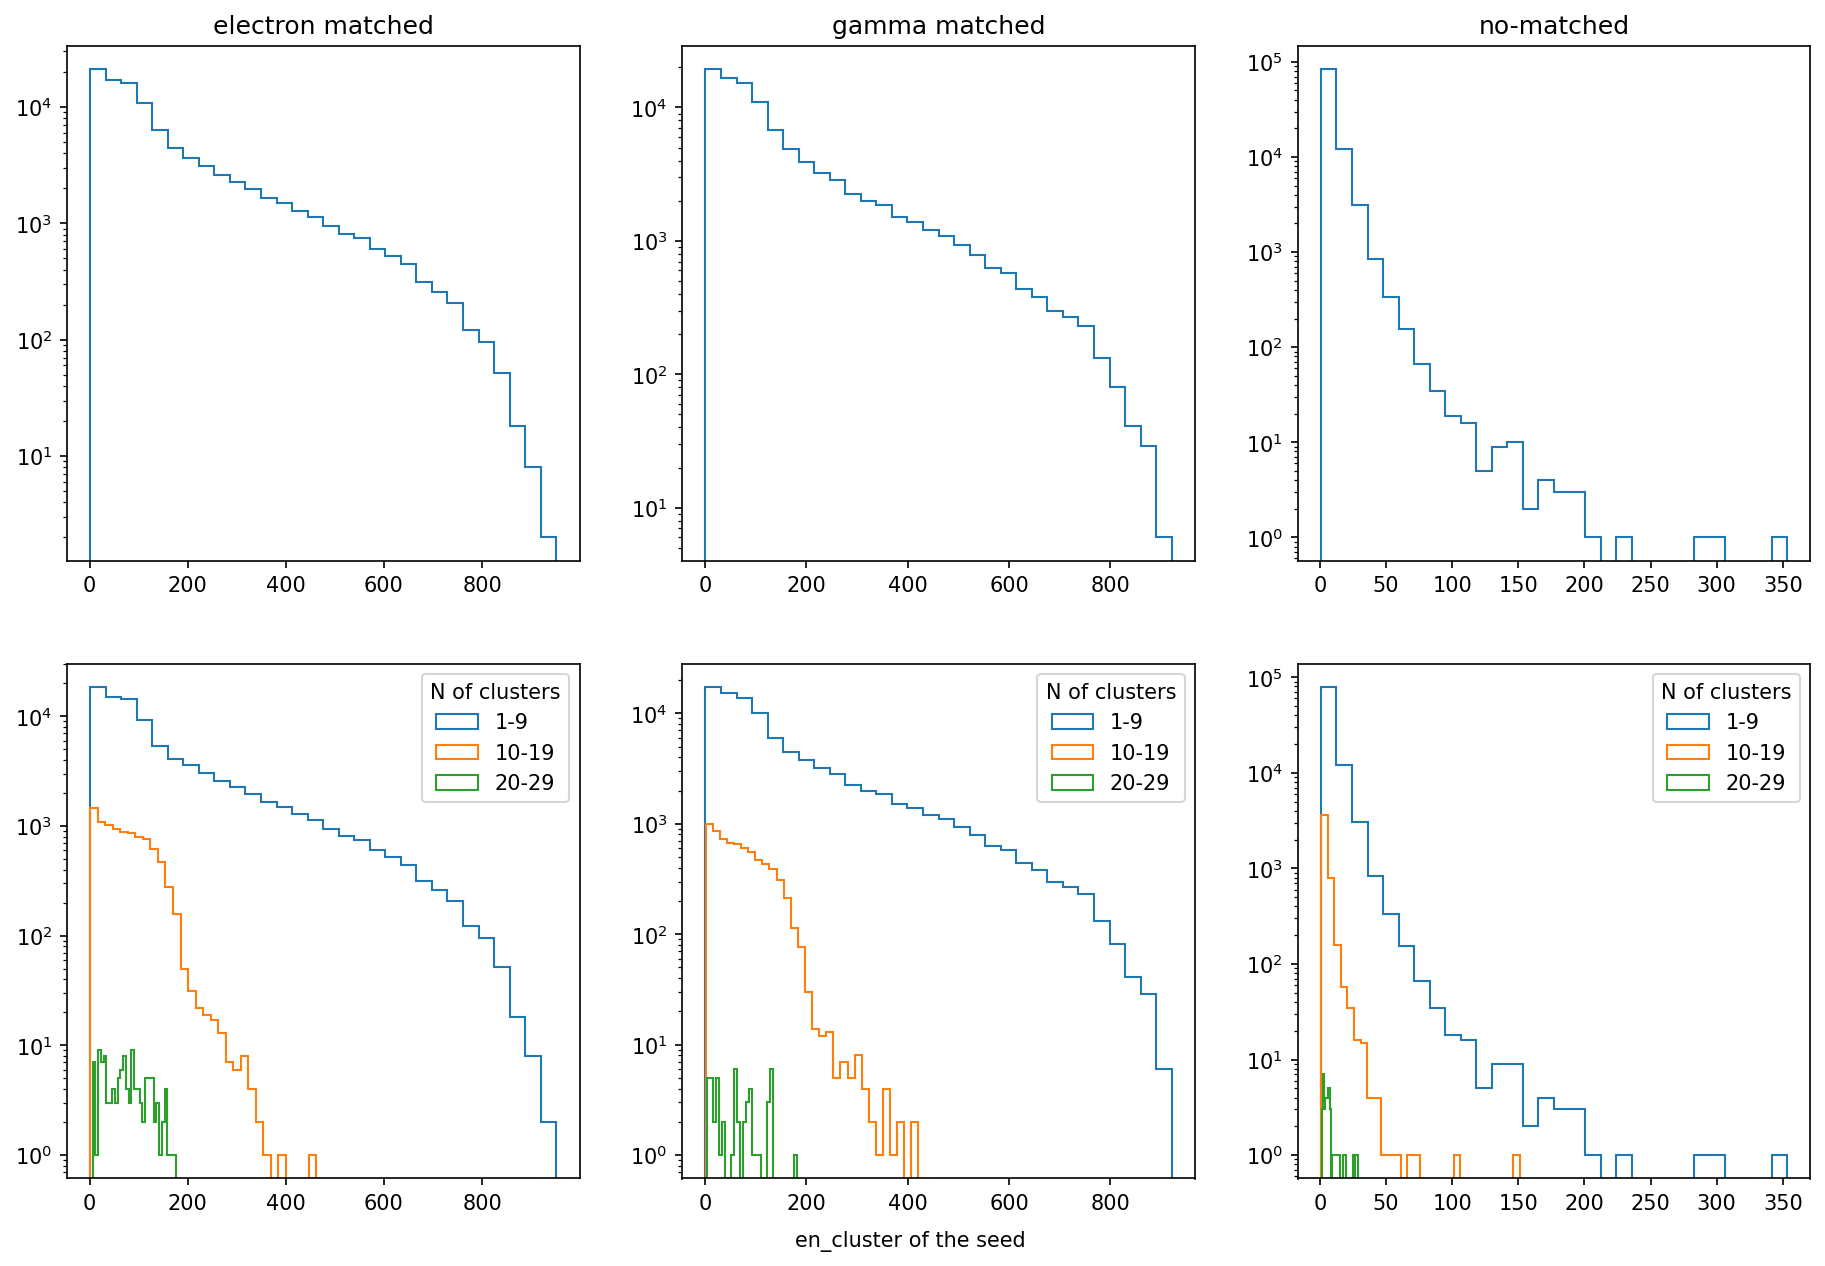

In [19]:
draw_seed('en_cluster')

# Et of the seed

In [20]:
def draw_seed(variable):
    fig, axis = plt.subplots(2, 3, figsize=(15,10))

    for i in range(len(df)):
        n_cl = df[i][variable][df[i]['is_seed'] == 1.]

        ax = axis[0,i]
        ax.hist(n_cl, bins=30, histtype="step")
        ax.set_title(df_title[i])
        ax.set_yscale("log")
        ax.set_xlabel('Et [GeV]')
        ax.set_ylim(1, 1e5)

        ax = axis[1, i]
        for j, n in enumerate(ncl_range):
            ax.hist(df[i][variable][df[i]['is_seed'] == 1.][df[i]['n_cl'].isin(n)], label=ncl_title[j], bins=30, histtype="step")
            ax.set_yscale("log")
            ax.legend(title="N of clusters")
            ax.set_xlabel('Et [GeV]')
            ax.set_ylim(1, 1e5)
            
    #fig.text(0.5, 0.08, variable+ ' of the seed', ha='center')

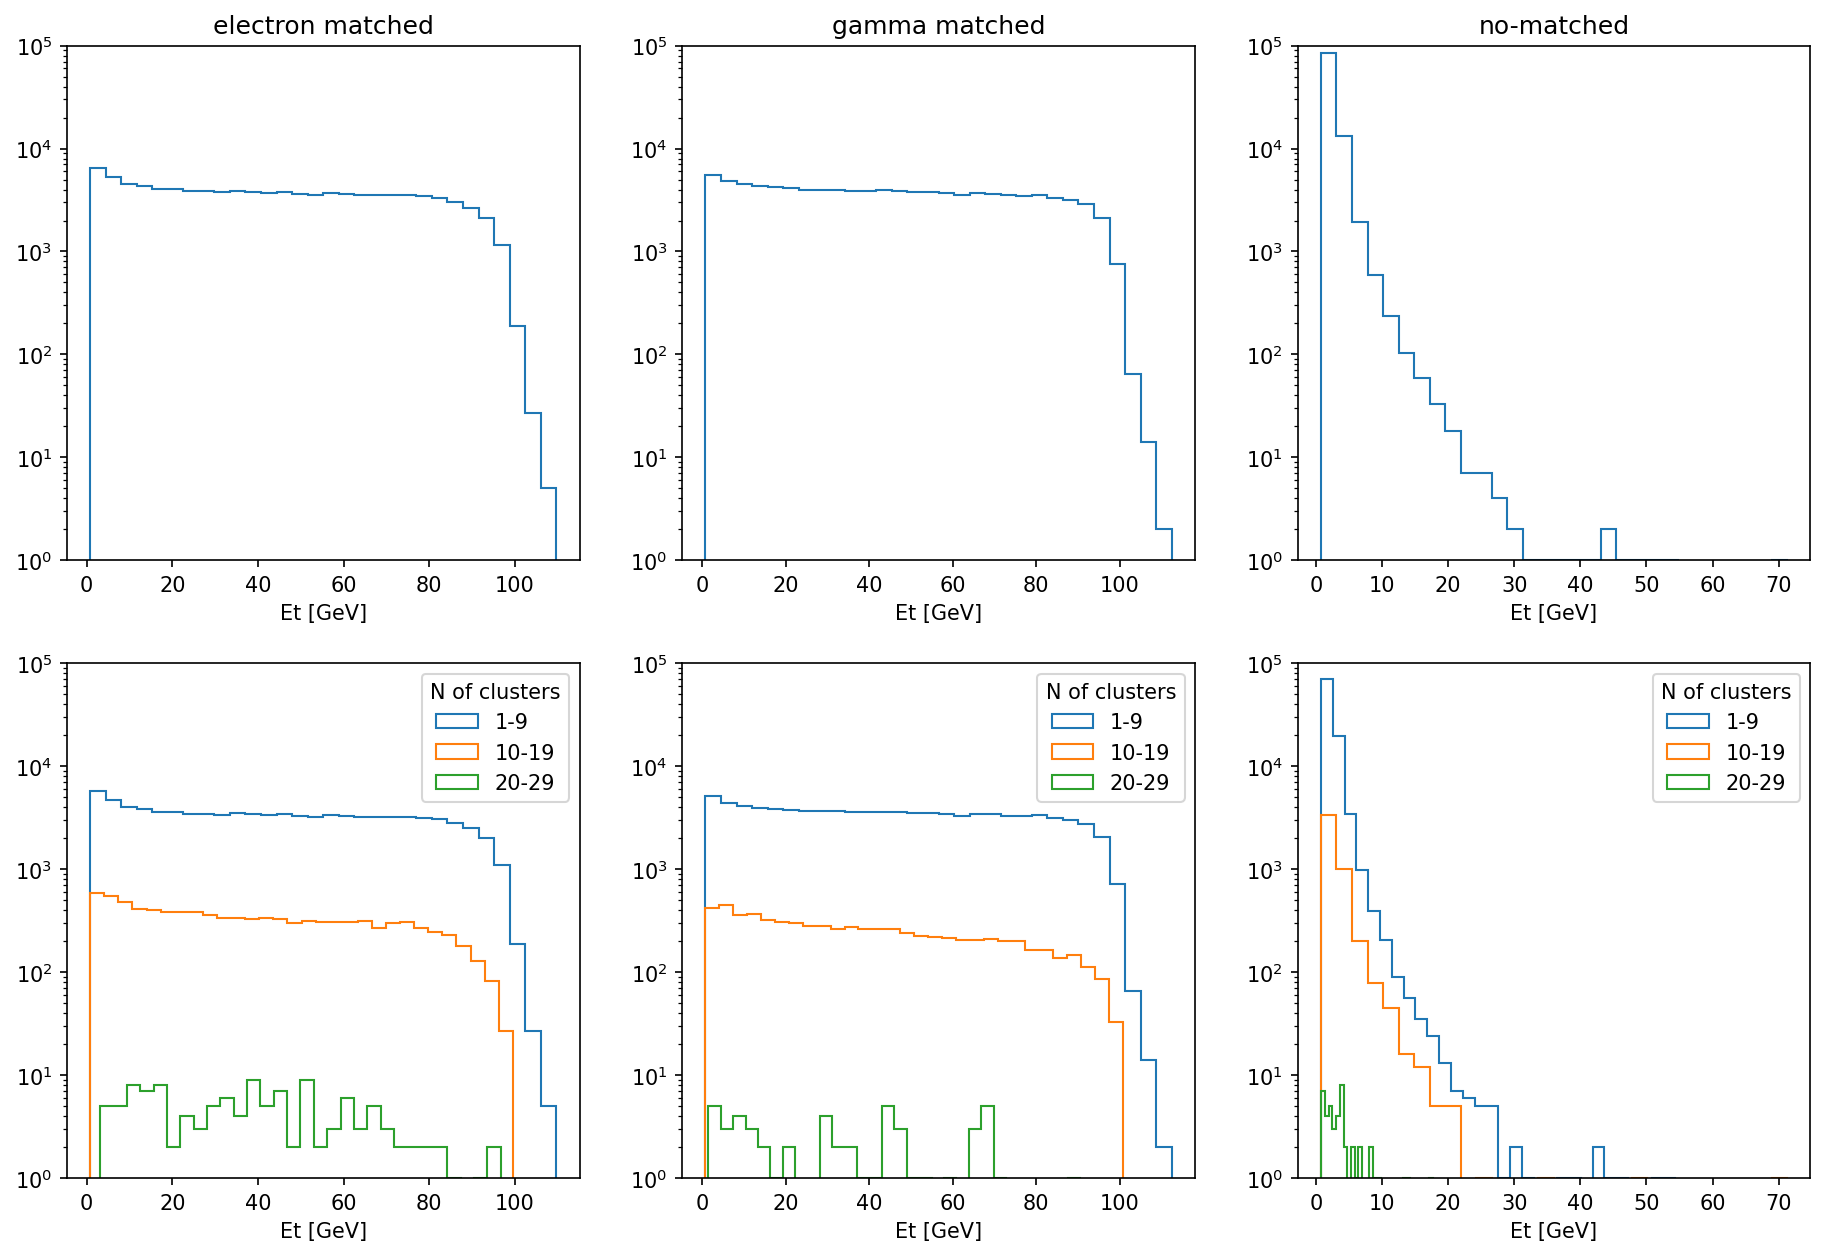

In [21]:
draw_seed('et_cluster')

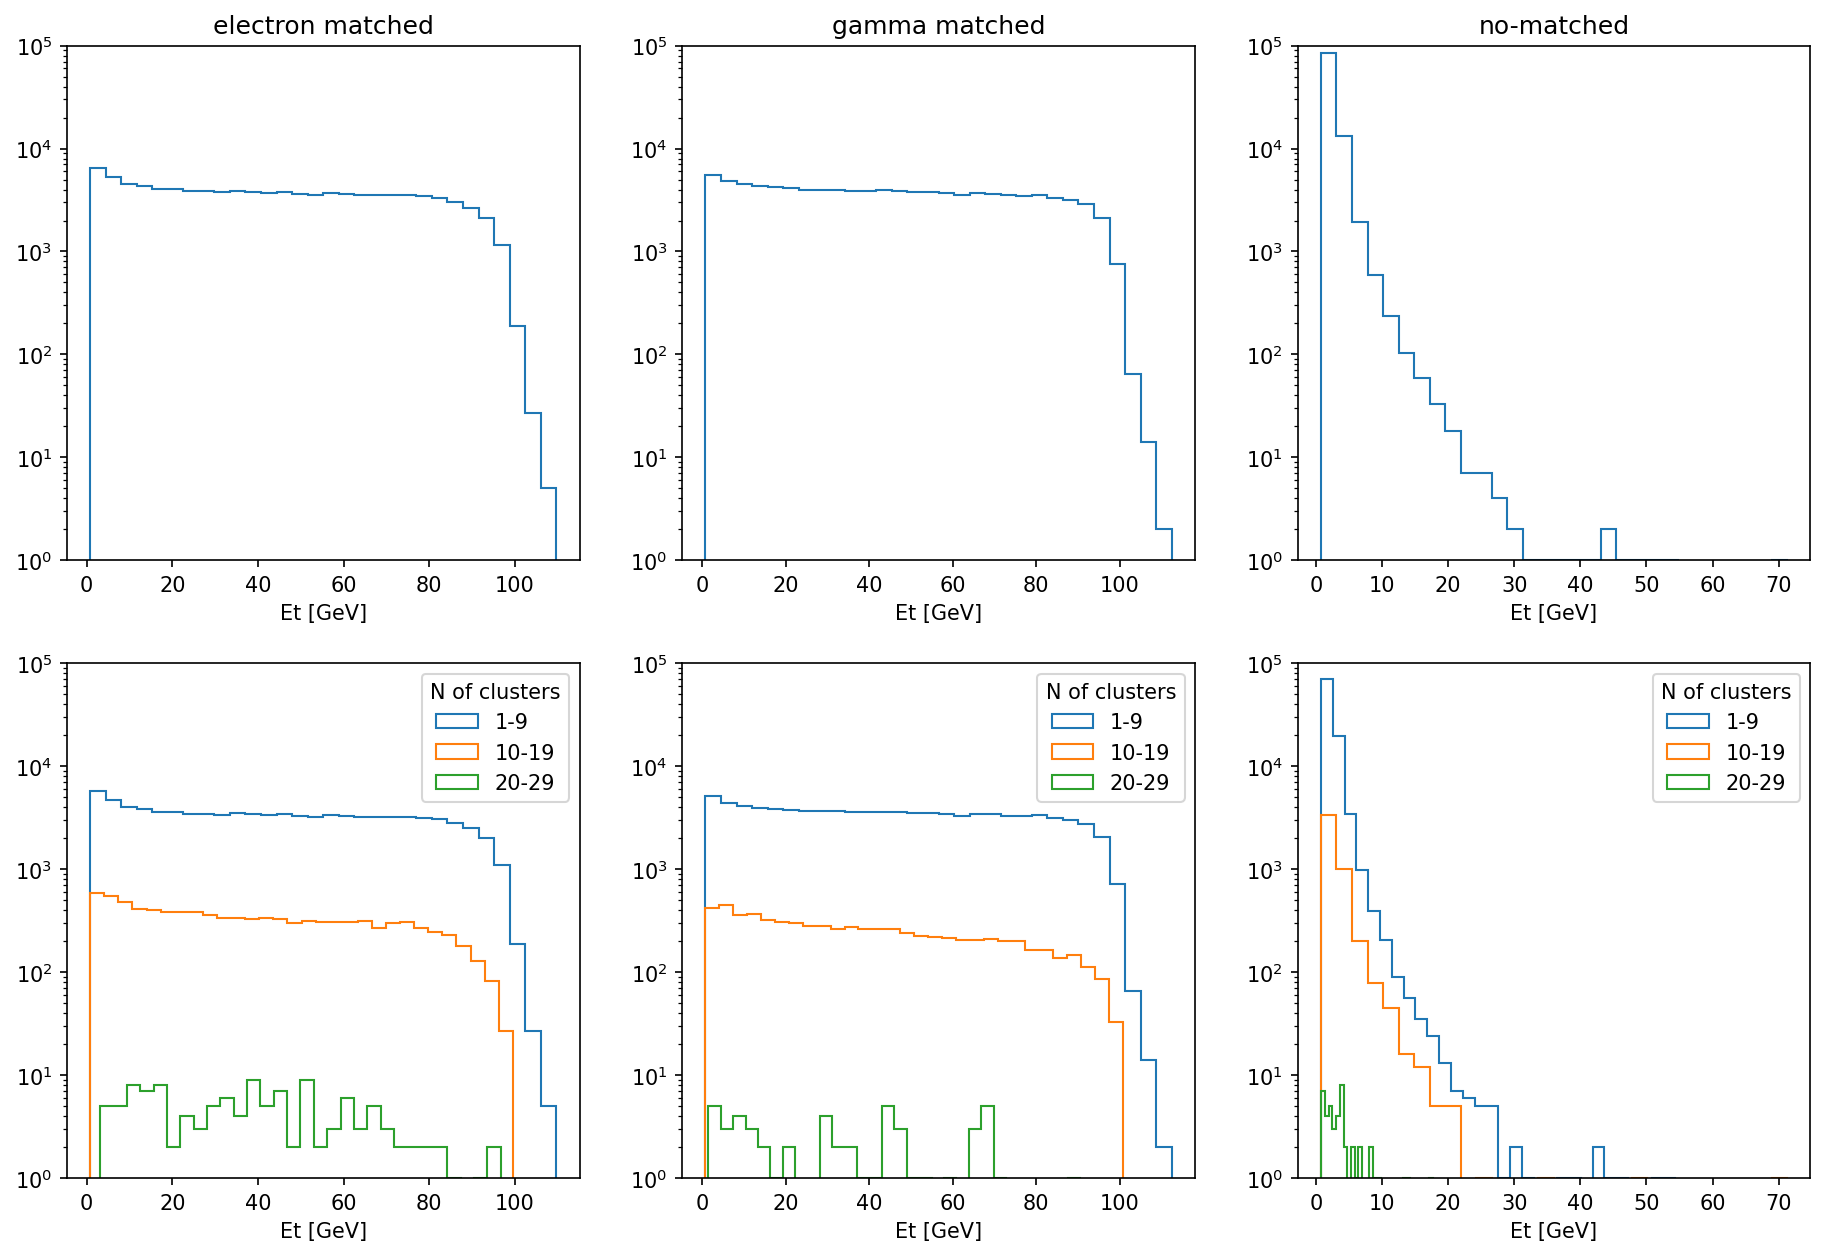

In [22]:
draw_seed('et_cluster')

# iphi of the seed

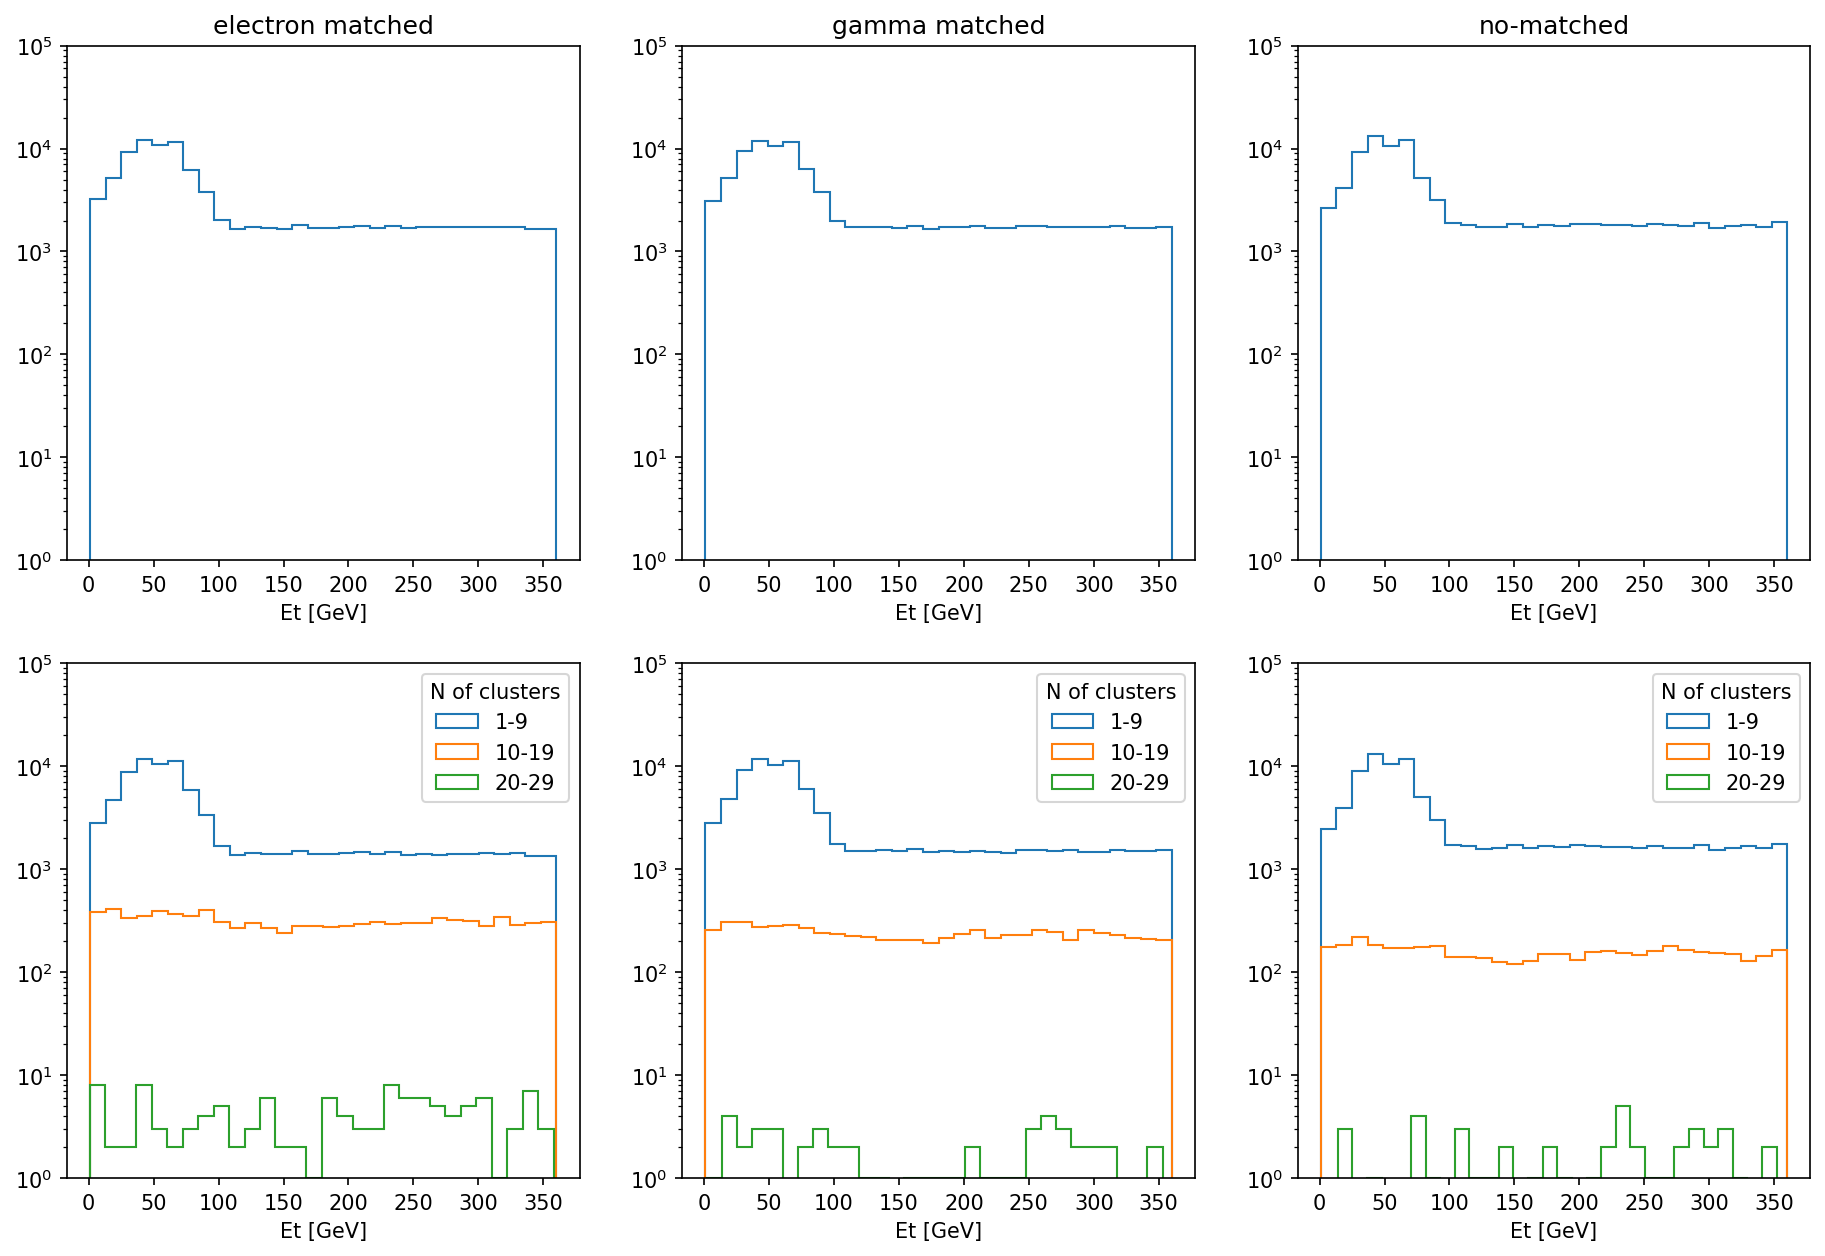

In [23]:
draw_seed('cluster_iphi')

# eta of the seed

In [24]:
def draw_seed(variable):
    fig, axis = plt.subplots(2, 3, figsize=(15,10))
    #fig.tight_layout()
    for i in range(len(df)):
        n_cl = df[i][variable][df[i]['is_seed'] == 1.]

        ax = axis[0,i]
        ax.hist(n_cl, bins=30, histtype="step")
        ax.set_title(df_title[i])
        #ax.set_yscale("log")
        ax.set_xlabel('eta')
        #ax.set_ylim(1, 1e5)

        ax = axis[1, i]
        for j, n in enumerate(ncl_range):
            ax.hist(df[i][variable][df[i]['is_seed'] == 1.][df[i]['n_cl'].isin(n)], label=ncl_title[j], bins=30, histtype="step")
            ax.set_yscale("log")
            ax.legend(title="N of clusters")
            ax.set_xlabel('eta')
            #ax.set_ylim(1, 1e5)
            
    #fig.text(0.5, 0.08, variable+ ' of the seed', ha='center')

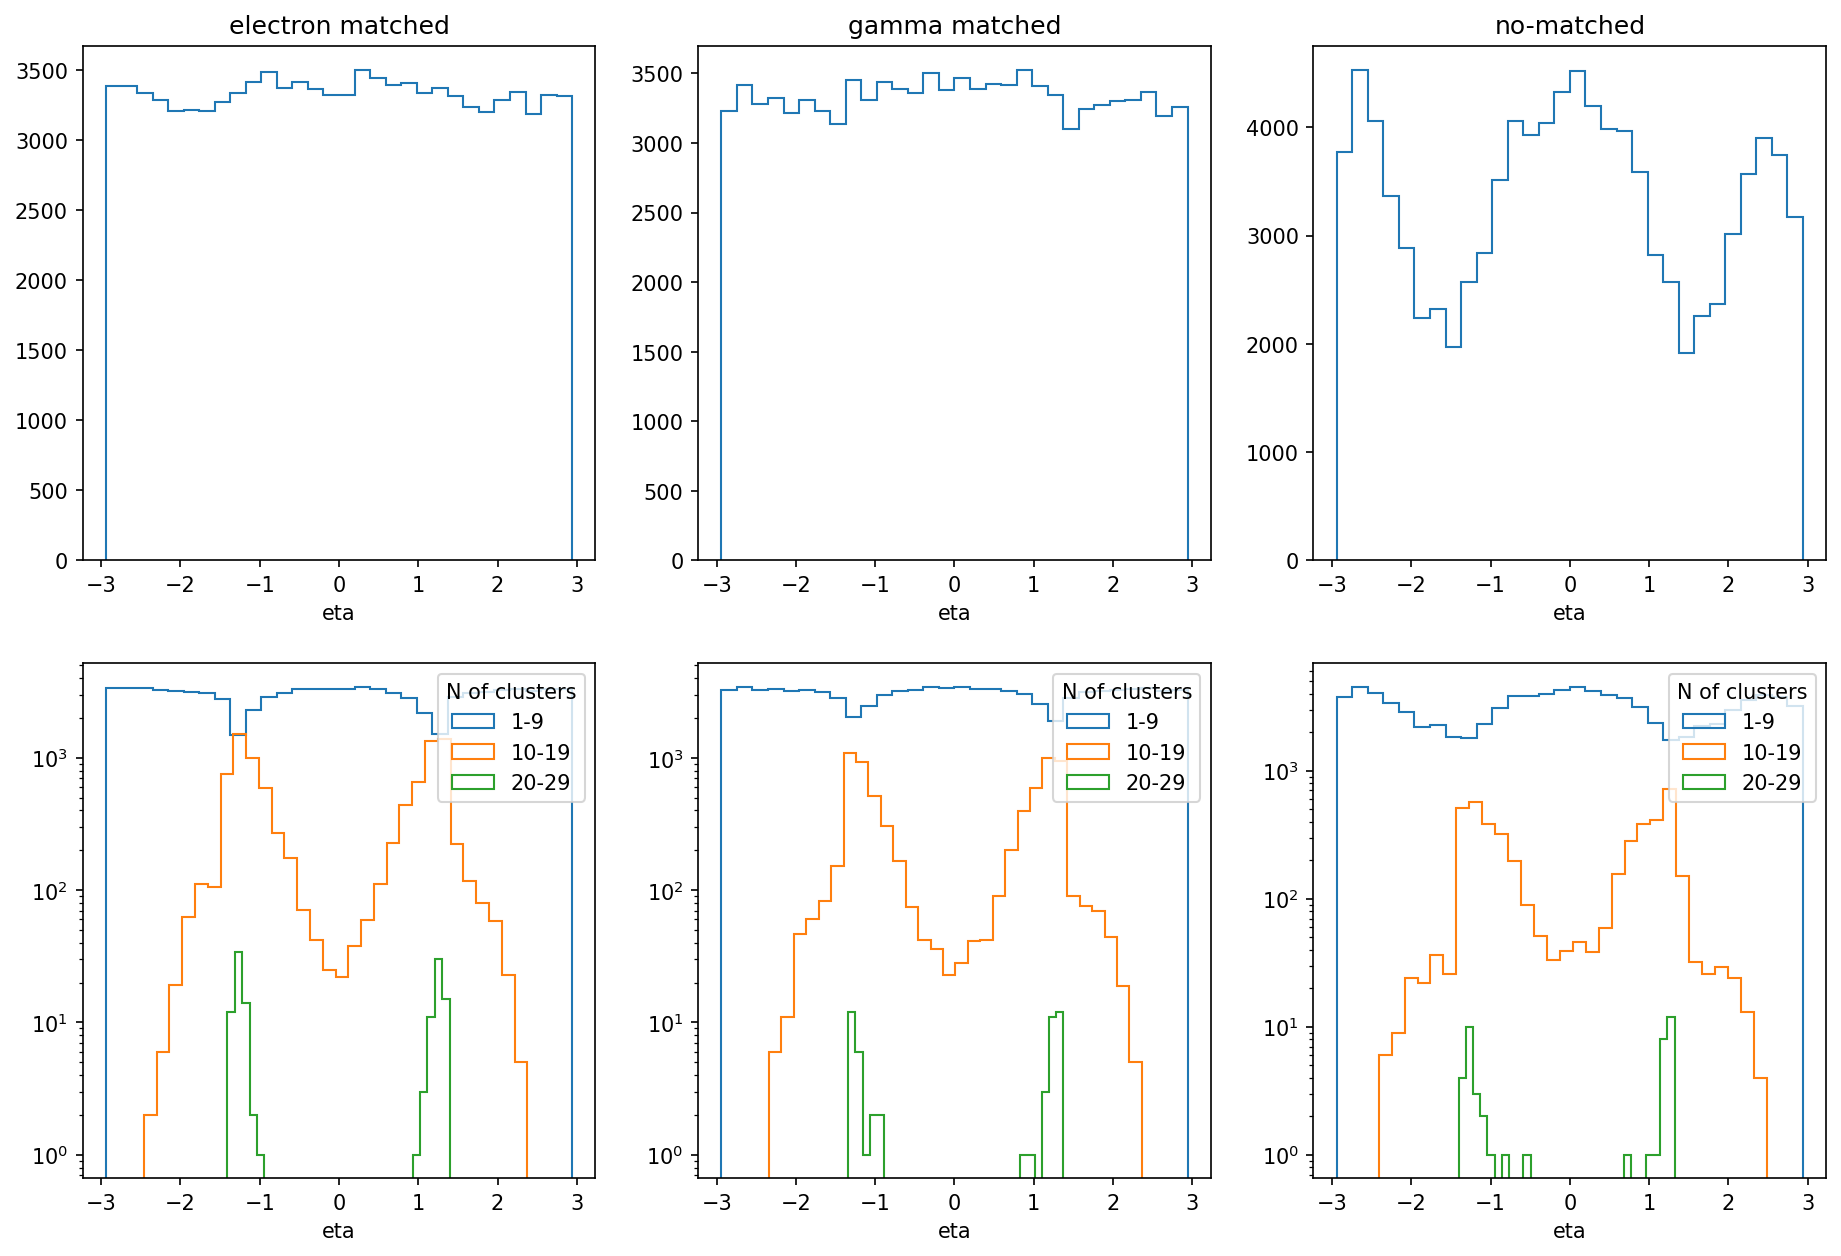

In [25]:
draw_seed('seed_eta')

# Energy distribution of clusters

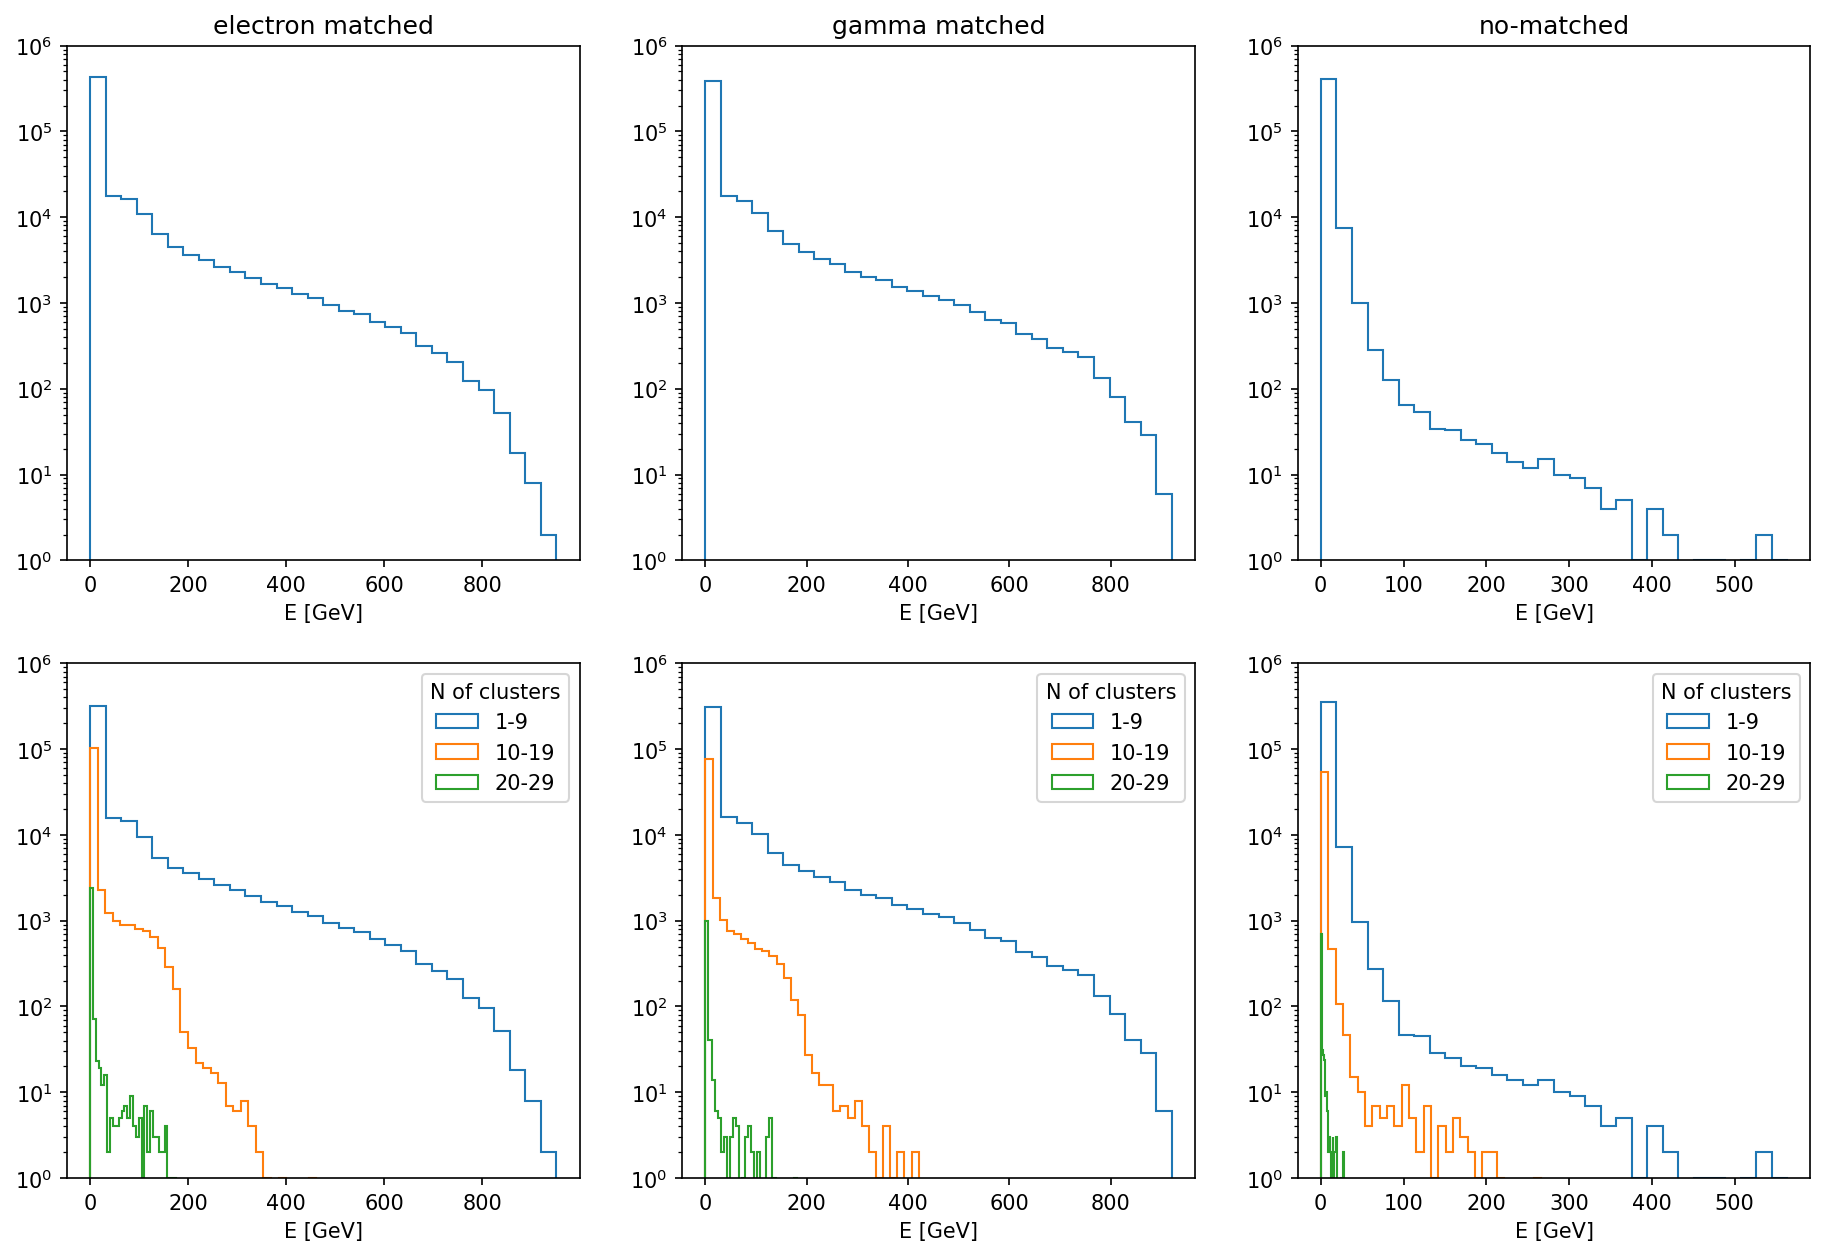

In [26]:
fig, axis = plt.subplots(2, 3, figsize=(15,10))

for i in range(len(df)):
    ax = axis[0,i]
    
    ax.hist(df[i]['en_cluster'], bins=30, histtype="step")
    ax.set_yscale("log")
    ax.set_title(df_title[i])
    ax.set_xlabel('E [GeV]')
    ax.set_ylim(1, 1e6)
    
    ax = axis[1, i]
    for j, n in enumerate(ncl_range):
        ax.hist(df[i]['en_cluster'][df[i]['n_cl'].isin(n)], label=ncl_title[j], bins=30, histtype="step")
    ax.set_yscale("log")
    ax.legend(title="N of clusters")
    ax.set_xlabel('E [GeV]')
    ax.set_ylim(1, 1e6)
#fig.text(0.5, 0.08, 'E', ha='center')
#fig.text(0.08, 0.25, '# of clusters', va='center', rotation='vertical')

# Et distribution of clusters

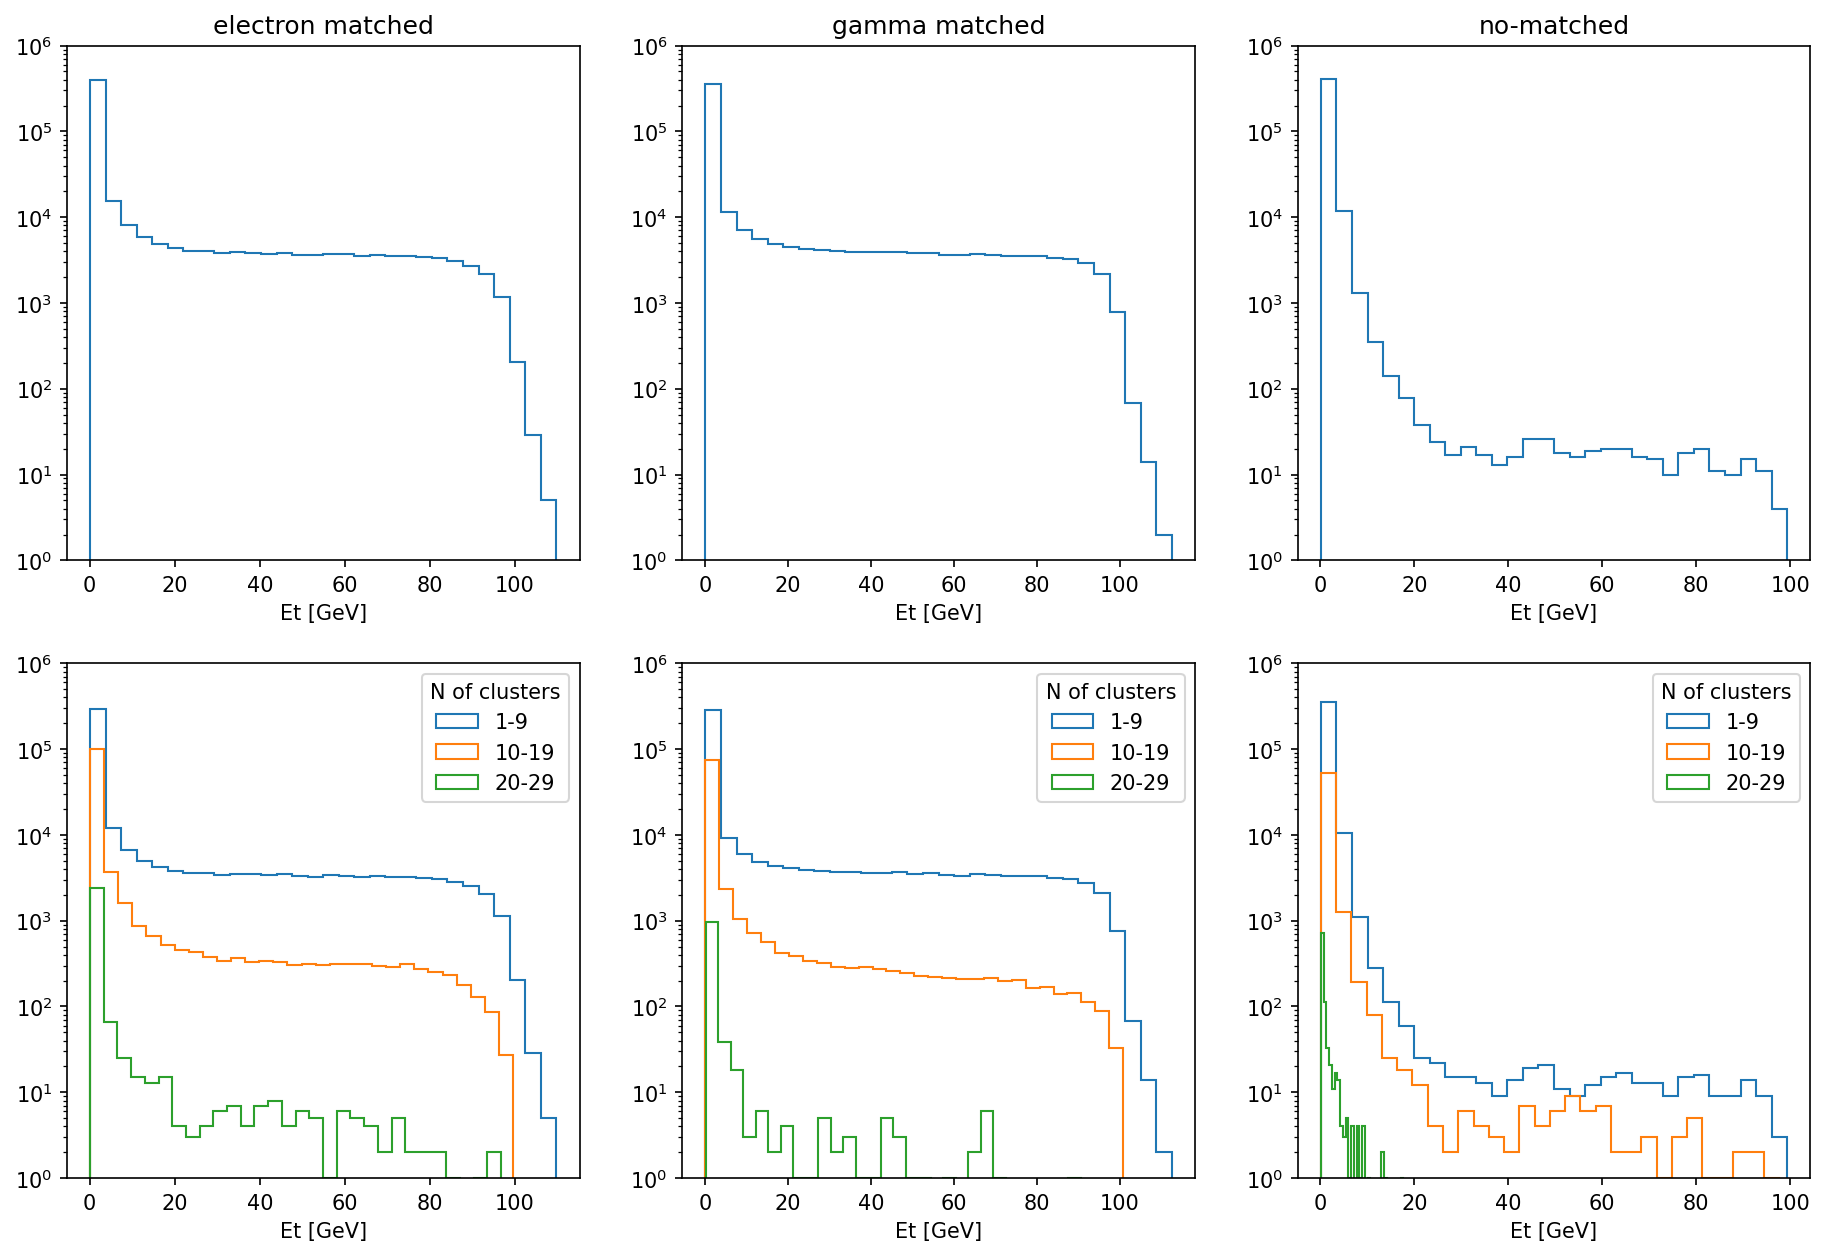

In [27]:
fig, axis = plt.subplots(2, 3, figsize=(15,10))

for i in range(len(df)):
    ax = axis[0,i]
    
    ax.hist(df[i]['et_cluster'], bins=30, histtype="step")
    ax.set_yscale("log")
    ax.set_title(df_title[i])
    ax.set_xlabel('Et [GeV]')
    ax.set_ylim(1, 1e6)

    ax = axis[1, i]
    for j, n in enumerate(ncl_range):
        ax.hist(df[i]['et_cluster'][df[i]['n_cl'].isin(n)], label=ncl_title[j], bins=30, histtype="step")
    ax.set_yscale("log")
    ax.legend(title="N of clusters")
    ax.set_xlabel('Et [GeV]')
    ax.set_ylim(1, 1e6)
#fig.text(0.5, 0.08, 'Et', ha='center')
#fig.text(0.08, 0.25, '# of clusters', va='center', rotation='vertical')

# N clusters vs. N clusters in SC

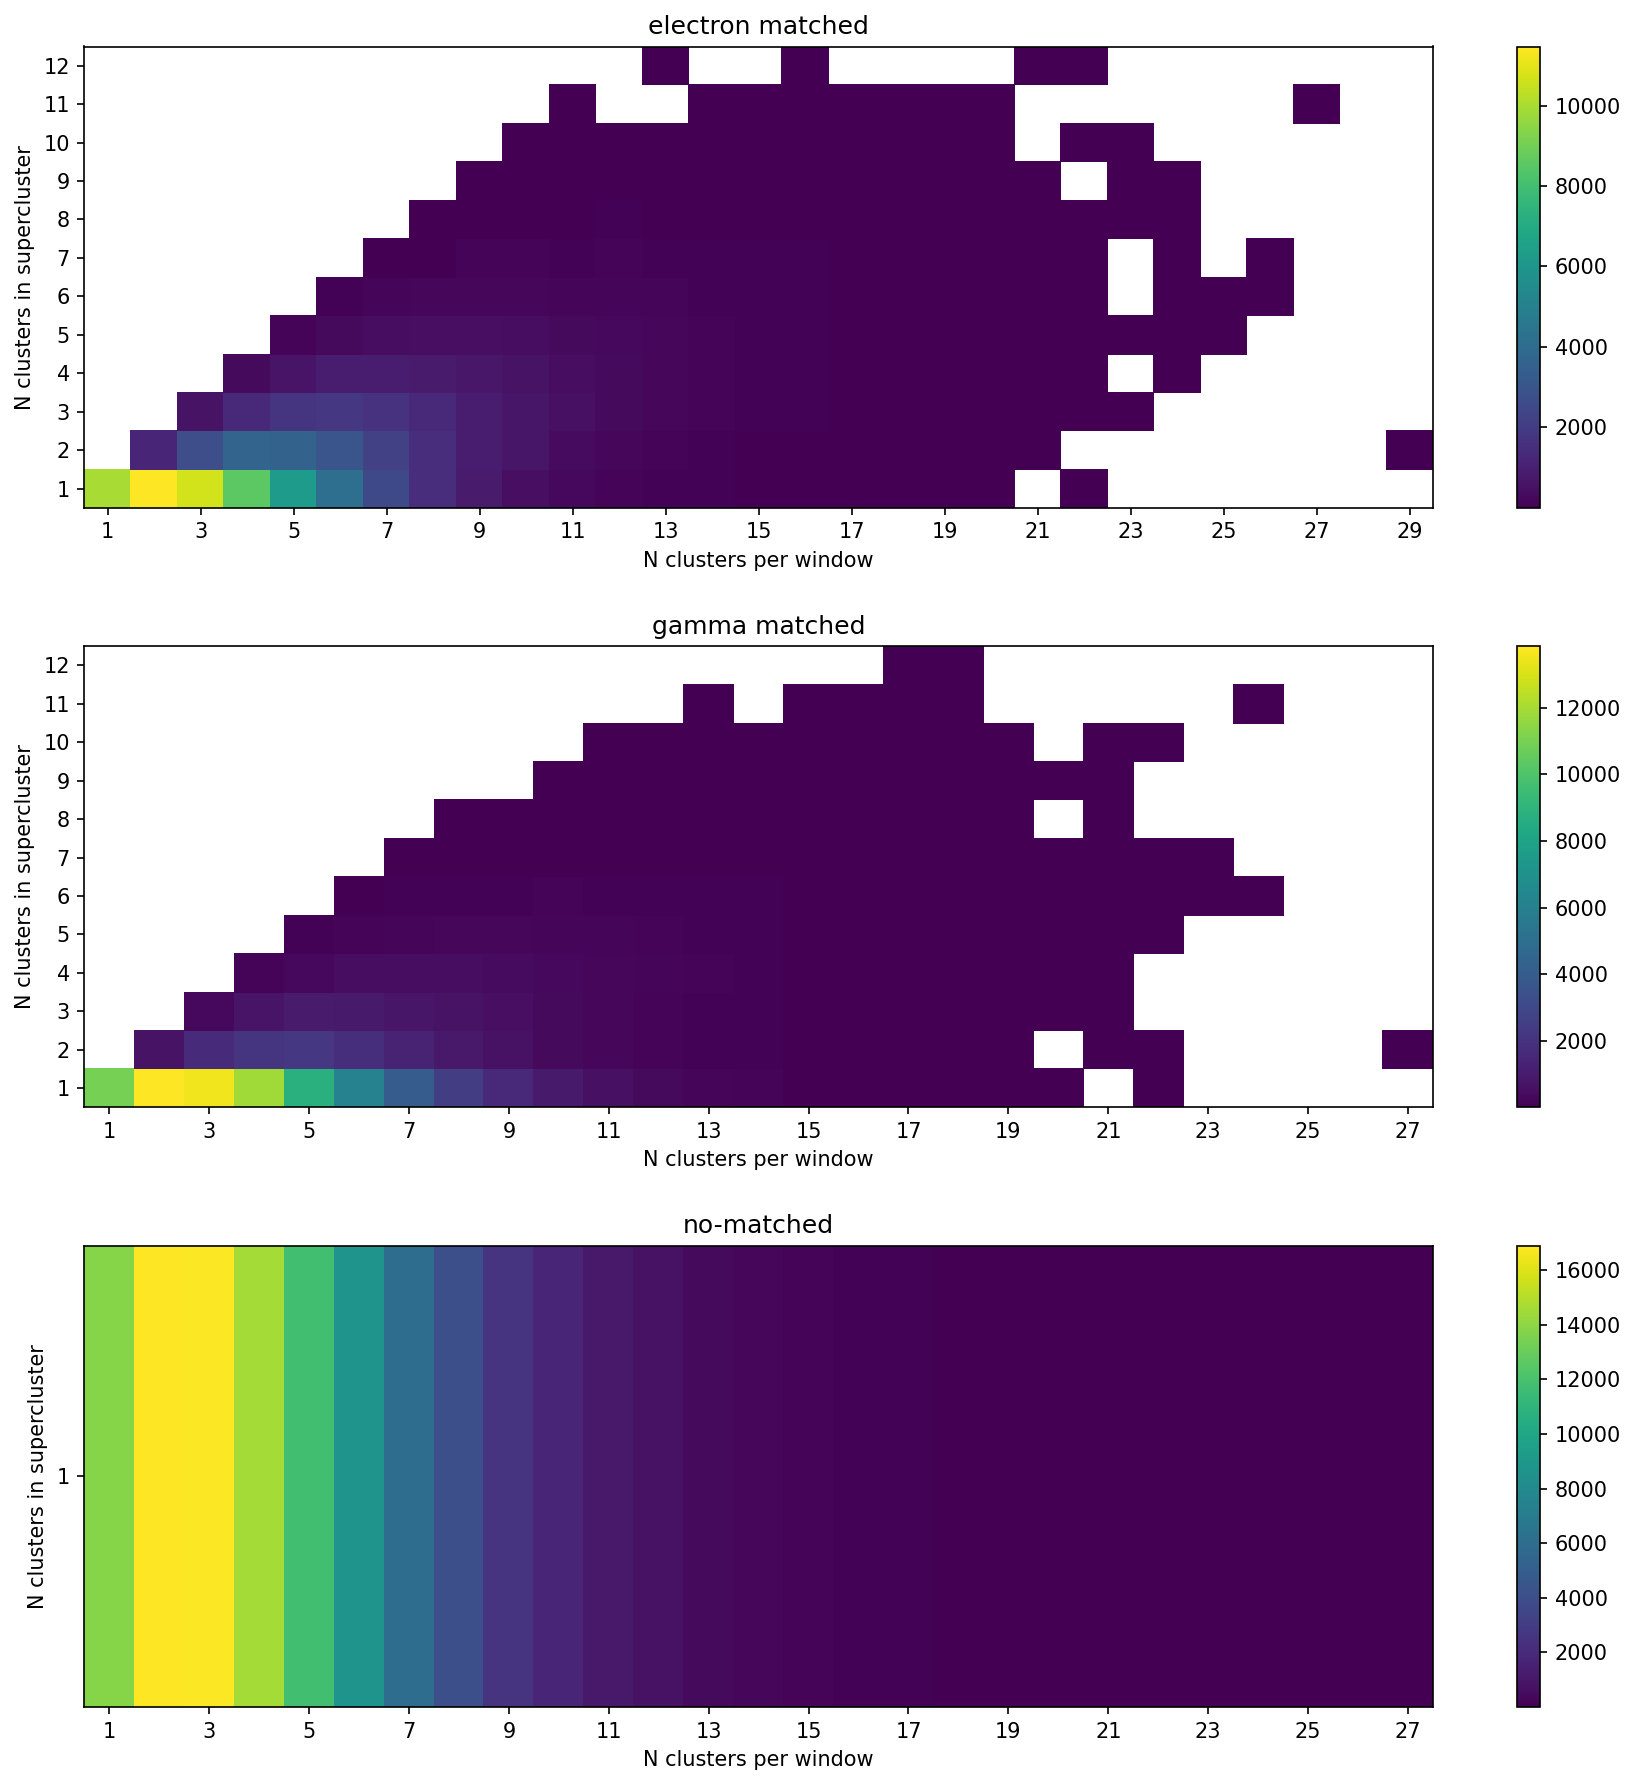

In [28]:
fig, axis = plt.subplots(3, figsize=(12,12))

for i, d in enumerate(df):
    ax = axis[i]
    
    n_cl = d['n_cl'][d['is_seed'] == 1.]
    in_sc = d['in_sc'].sum(level=0)
    
    C, xedges, yedges = np.histogram2d(n_cl, in_sc, bins=[max(n_cl), max(in_sc)], range=[[min(n_cl)-0.5, max(n_cl)+0.5],[min(in_sc)-0.5, max(in_sc)+0.5]])
    X, Y = np.meshgrid(xedges, yedges)
    C[C==0.] = np.nan 
    
    p = ax.pcolormesh(X, Y, C.T, cmap = 'viridis')
    plt.colorbar(p, ax=ax)
    ax.set_xlabel('N clusters per window')
    ax.set_ylabel('N clusters in supercluster')
    ax.set_xticks(np.arange(min(n_cl), max(n_cl)+2,2))
    ax.set_yticks(np.arange(min(in_sc), max(in_sc)+1,1))
    ax.set_title(df_title[i])
    
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

In [29]:
energy_range = [[0,20], [20,40], [40,60]]
energy_title = ['0 - 20', '20 - 40', '40 - 60', '60 - 80', '80 - 100']

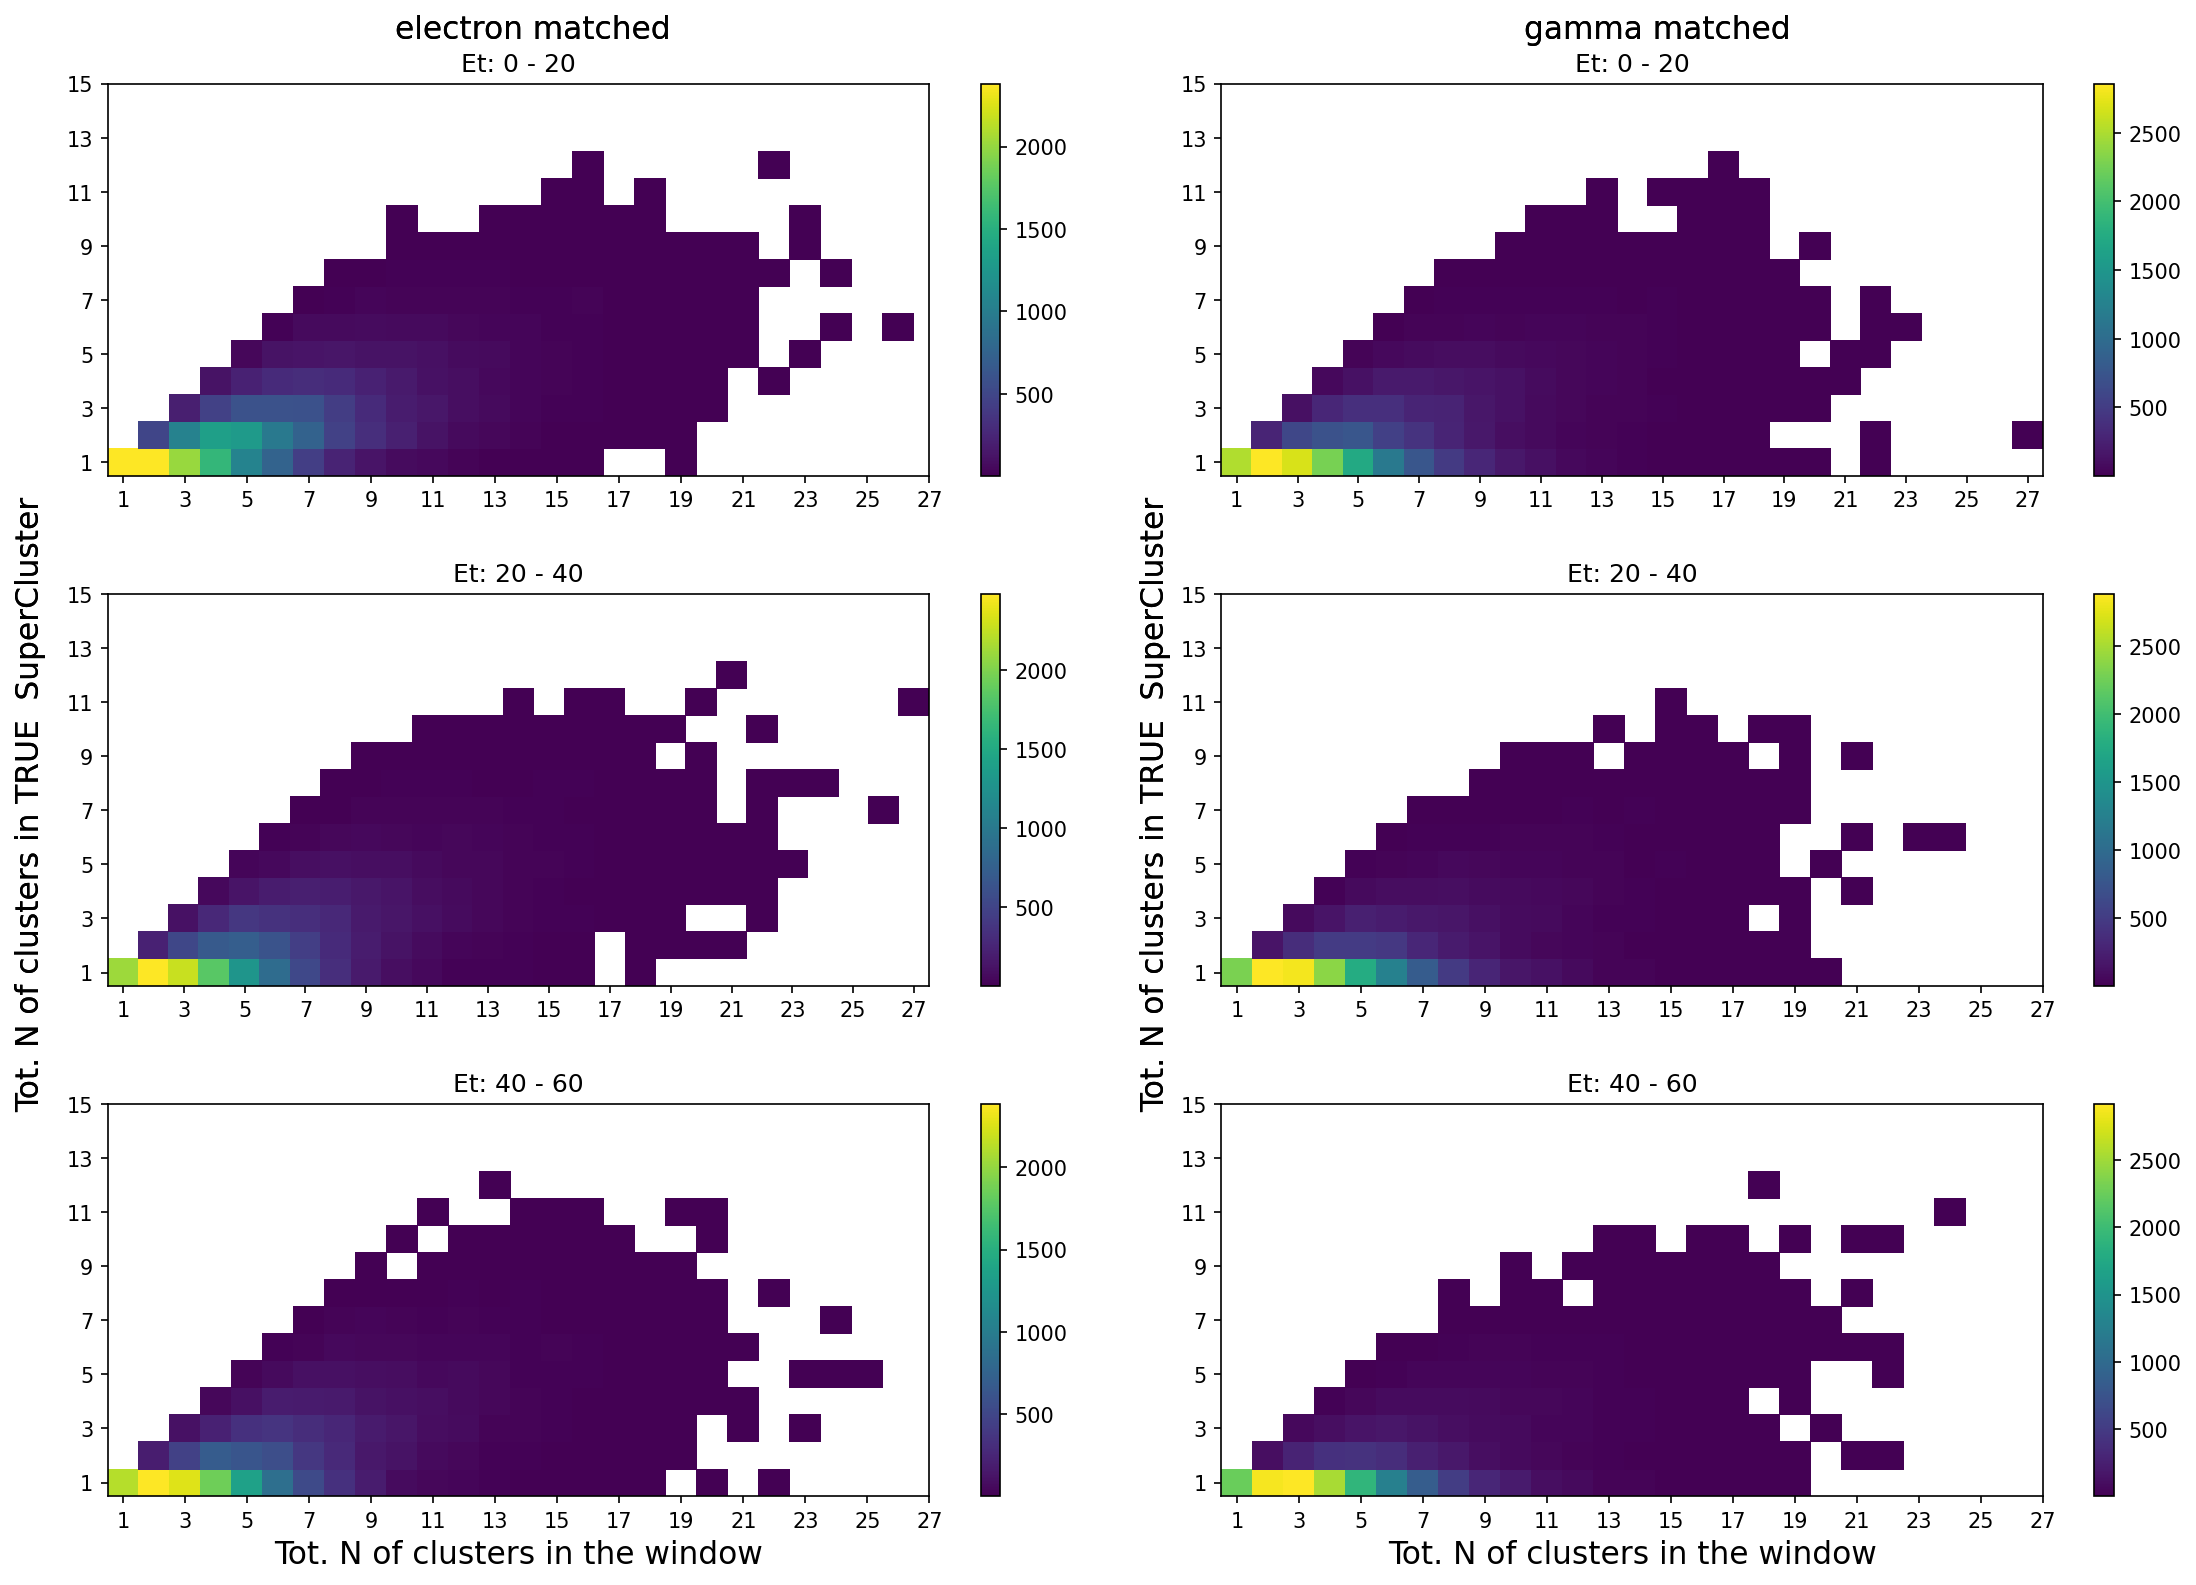

In [30]:
fig, axis = plt.subplots(3, 2, figsize=(15,10))
fig.tight_layout()

for i, d in enumerate(df[:-1]):
    
    seed = d[['n_cl', 'et_cluster']][d['is_seed'] == 1.]
    seed['in_sc'] = d['in_sc'].sum(level=0).values
    
    ax = axis[0,i]
    
    for j, en in enumerate(energy_range): 
        ax = axis[j,i]
        n_cl = seed['n_cl'][(seed['et_cluster']>=en[0])&(seed['et_cluster']<en[1])]
        in_sc = seed['in_sc'][(seed['et_cluster']>=en[0])&(seed['et_cluster']<en[1])]
   
        C, xedges, yedges = np.histogram2d(n_cl, in_sc, bins=[max(n_cl), max(in_sc)], range=[[min(n_cl)-0.5, max(n_cl)+0.5],[min(in_sc)-0.5, max(in_sc)+0.5]])
        X, Y = np.meshgrid(xedges, yedges)
        C[C==0.] = np.nan 
    
        p = ax.pcolormesh(X, Y, C.T, cmap = 'viridis')
        plt.colorbar(p, ax=ax)
        
        ax.set_xticks(np.arange(min(n_cl), 27+2,2))
        ax.set_yticks(np.arange(min(in_sc), 15+2,2))
        
        ax.set_title('Et: ' + energy_title[j])
        #ax.set_xlabel('Tot. N of clusters in the window')
        #ax.set_ylabel('Tot. N of clusters in TRUE  SuperCluster')
    ax.set_xlabel('Tot. N of clusters in the window', fontsize=15.)
    fig.text(-0.01, 0.5, 'Tot. N of clusters in TRUE  SuperCluster', va='center', rotation='vertical', fontsize=15.)
    fig.text(0.49, 0.5, 'Tot. N of clusters in TRUE  SuperCluster', va='center', rotation='vertical', fontsize=15.)
    fig.text(0.22, 1.01, df_title[0], ha='center', fontsize=15.)
    fig.text(0.72, 1.01, df_title[1], ha='center', fontsize=15.)
    fig.subplots_adjust(hspace=0.3)

In [31]:
energy_range = [[0,1], [1,3], [3,5], [5,7], [7,10], [10,13], [13,16], [16,20]]
energy_title = ['0 - 1', '1 - 3', '3 - 5', '5 - 7', '7 - 10', '10-13', '13-16', '16-20']

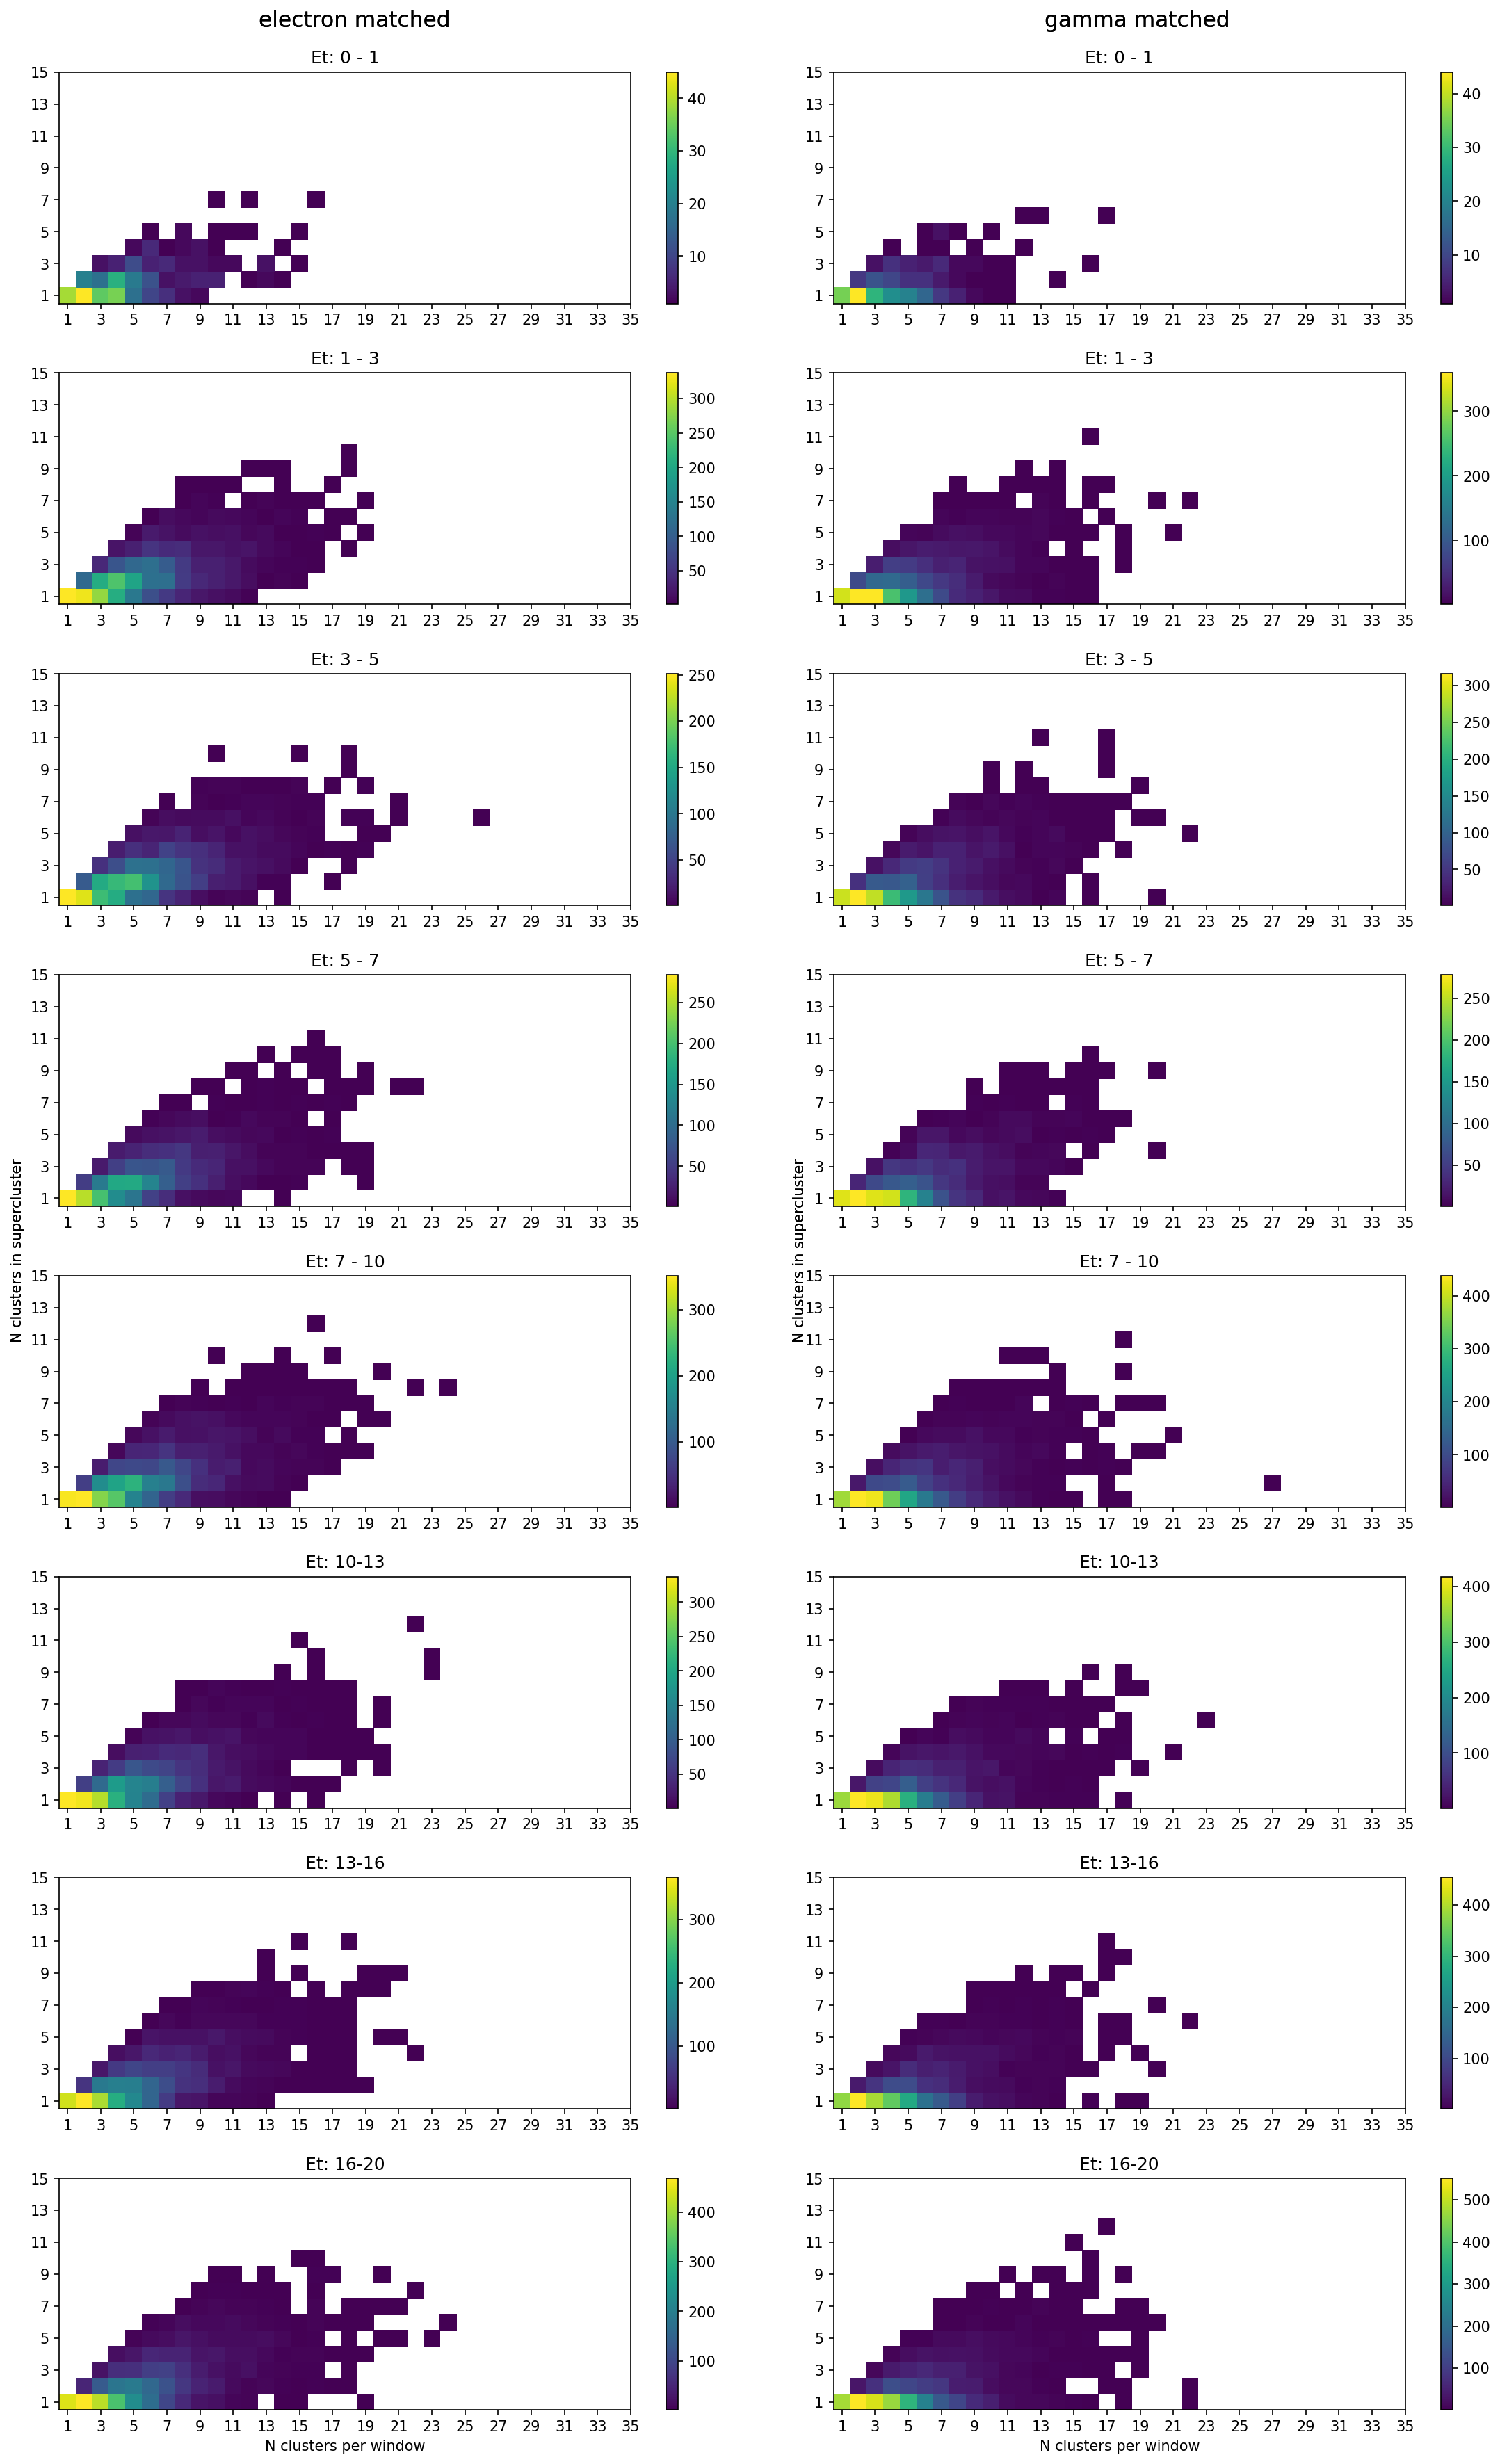

In [32]:
fig, axis = plt.subplots(len(energy_range), 2, figsize=(15,23))
fig.tight_layout()

for i, d in enumerate(df[:-1]):
    
    seed = d[['n_cl', 'et_cluster']][d['is_seed'] == 1.]
    seed['in_sc'] = d['in_sc'].sum(level=0).values
    
    ax = axis[0,i]
    
    for j, en in enumerate(energy_range): 
        ax = axis[j,i]
        n_cl = seed['n_cl'][(seed['et_cluster']>=en[0])&(seed['et_cluster']<en[1])]
        in_sc = seed['in_sc'][(seed['et_cluster']>=en[0])&(seed['et_cluster']<en[1])]
   
        C, xedges, yedges = np.histogram2d(n_cl, in_sc, bins=[max(n_cl), max(in_sc)], range=[[min(n_cl)-0.5, max(n_cl)+0.5],[min(in_sc)-0.5, max(in_sc)+0.5]])
        X, Y = np.meshgrid(xedges, yedges)
        C[C==0.] = np.nan 
    
        p = ax.pcolormesh(X, Y, C.T, cmap = 'viridis')
        plt.colorbar(p, ax=ax)
        
        ax.set_xticks(np.arange(min(n_cl), 34+2,2))
        ax.set_yticks(np.arange(min(in_sc), 15+2, 2))
        
        ax.set_title('Et: ' + energy_title[j])

    ax.set_xlabel('N clusters per window')
    fig.text(0.0, 0.5, 'N clusters in supercluster', va='center', rotation='vertical')
    fig.text(0.5, 0.5, 'N clusters in supercluster', va='center', rotation='vertical')
    fig.text(0.22, 1.01, df_title[0], ha='center', fontsize=15.)
    fig.text(0.72, 1.01, df_title[1], ha='center', fontsize=15.)
    fig.subplots_adjust(hspace=0.3)